In [2]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(useful)) 
suppressPackageStartupMessages(library(ggplot2)) 
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(limma)) 
suppressPackageStartupMessages(library(EnhancedVolcano)) 
suppressPackageStartupMessages(library(biomaRt)) 
suppressPackageStartupMessages(library(gridExtra)) 
suppressPackageStartupMessages(library(repr)) 

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [3]:
data <- read.csv("bulk/stability_timepoints.tsv",sep="\t",header=T,quote="",row.names=1)
corner(data) 
meta <- read.csv("bulk/stability_timepoints_meta.tsv",sep="\t",header=T,row.names=1,quote="")

Stability_d21_sample_9 Stability_d21_sample_4 Stability_d21_sample_5
5S_rRNA   0                       6                      0                    
5_8S_rRNA 0                       0                      0                    
7SK       0                       0                      0                    
A1BG      3                       6                      5                    
A1BG-AS1  5                      13                     11                    
          Stability_d21_sample_10 Stability_d21_sample_7
5S_rRNA   0                        0                    
5_8S_rRNA 0                        0                    
7SK       0                        1                    
A1BG      4                       21                    
A1BG-AS1  4                        4

In [4]:
head(meta)

t   sample t_int
Stability_d21_sample_9  d21  9     21   
Stability_d21_sample_4  d21  4     21   
Stability_d21_sample_5  d21  5     21   
Stability_d21_sample_10 d21 10     21   
Stability_d21_sample_7  d21  7     21   
Stability_d21_sample_6  d21  6     21

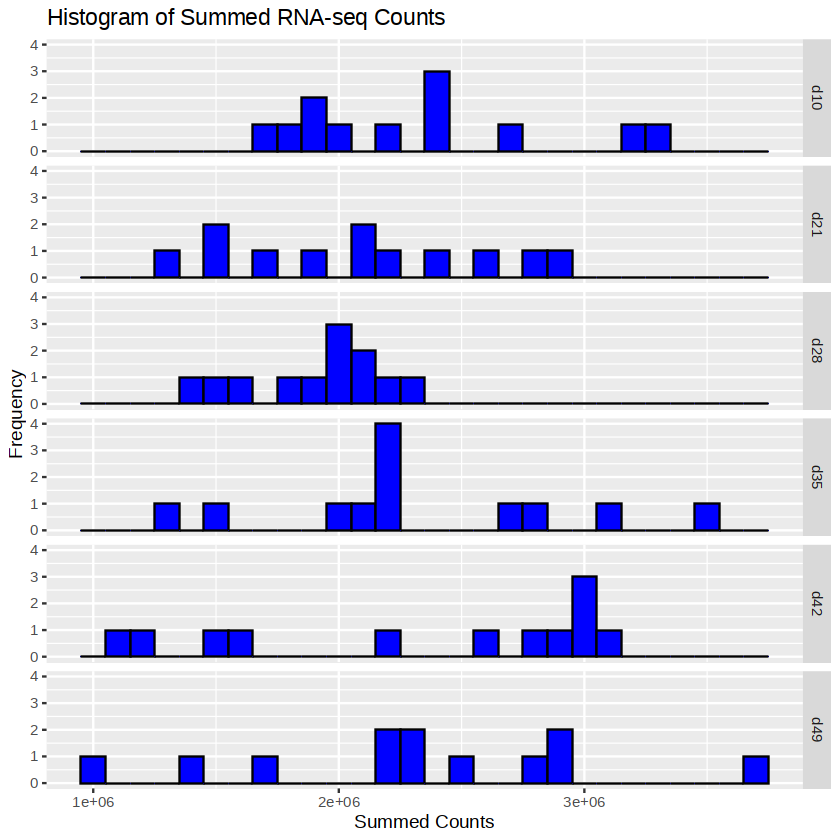

                         counts
Stability_d49_sample_1   993984
Stability_d42_sample_12 1080598
Stability_d42_sample_11 1181846
Stability_d35_sample_1  1285938
Stability_d21_sample_1  1305302
Stability_d49_sample_2  1378173
Stability_d28_sample_5  1427974
Stability_d21_sample_2  1457116
Stability_d35_sample_2  1465541
Stability_d21_sample_9  1492186
Stability_d42_sample_10 1499447
Stability_d28_sample_12 1511447
Stability_d42_sample_9  1623921
Stability_d28_sample_4  1645883
Stability_d21_sample_4  1667503
Stability_d10_sample_12 1699649
Stability_d49_sample_3  1719601
Stability_d28_sample_6  1807912
Stability_d10_sample_11 1822397
Stability_d10_sample_9  1851657


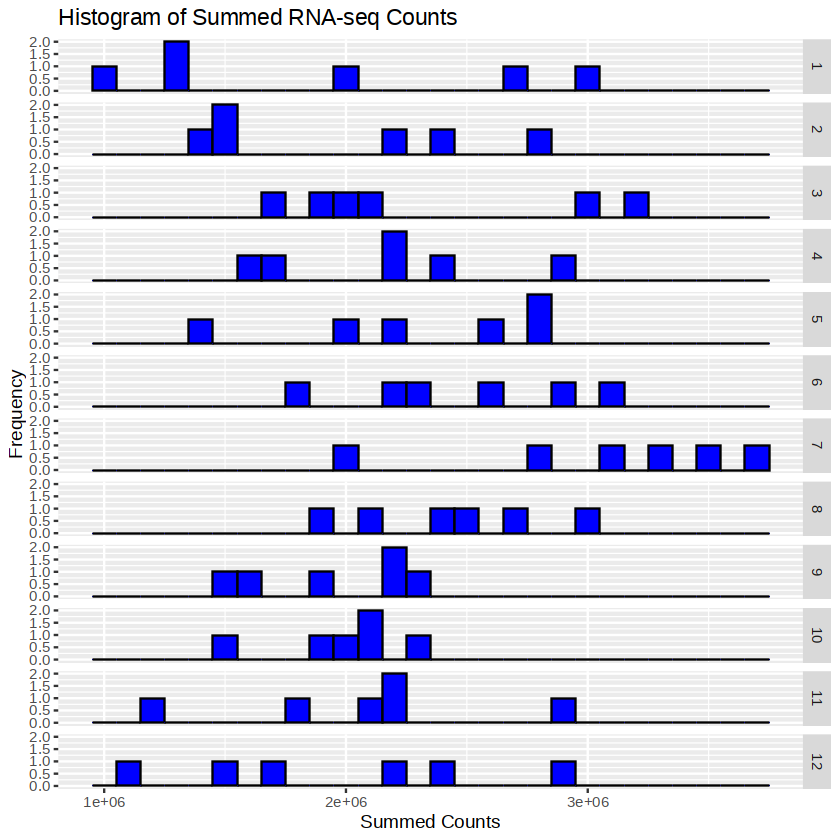

In [5]:

# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

meta['counts'] <- colSums(data)


# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(t ~ .)

# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(sample ~ .)

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)


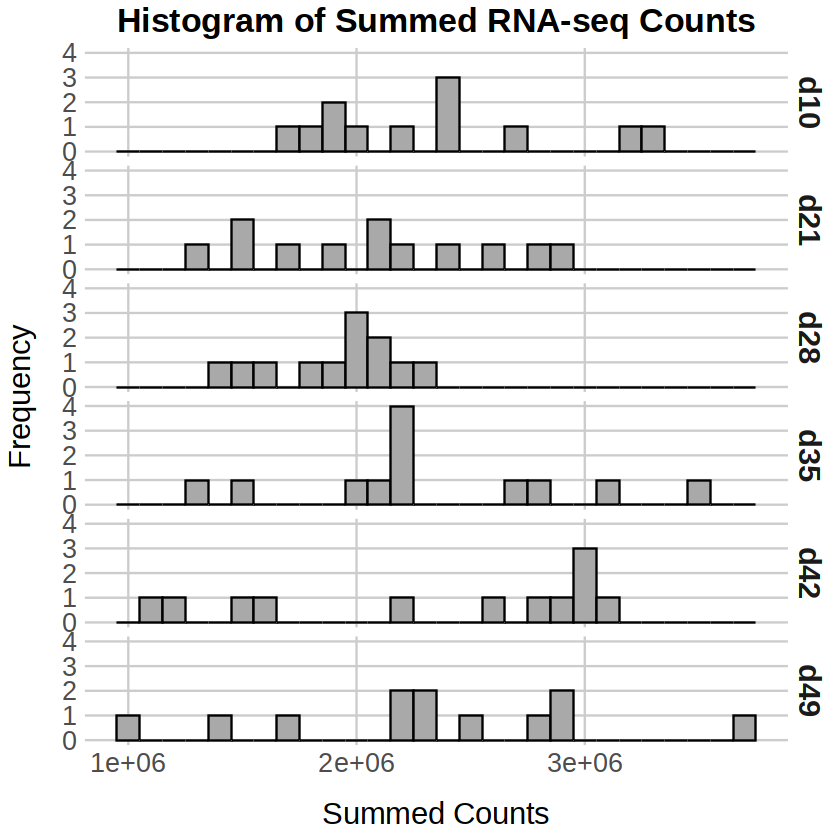

In [6]:
# Load necessary libraries
library(ggplot2)

# Create the plot and adjust aesthetics
p <- ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'darkgrey', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(t ~ .) +
  theme_minimal() +  # Clean theme
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),  # Larger title
    axis.title.x = element_text(size = 18, margin = margin(t = 15)),   # Larger x-axis label
    axis.title.y = element_text(size = 18, margin = margin(r = 15)),   # Larger y-axis label
    axis.text.x = element_text(size = 16),                            # Larger x-axis tick labels
    axis.text.y = element_text(size = 16),                            # Larger y-axis tick labels
    strip.text.y = element_text(size = 18, face = "bold"),            # Larger facet label text
    panel.grid.major = element_line(color = "gray80"),                # Lighter major gridlines
    panel.grid.minor = element_blank()                                # Remove minor gridlines
  )

# Export the plot to a PDF with increased size for clarity in publication
ggsave("stability_plots/Summed_RNAseq_Histogram.pdf", plot = p, width = 10, height = 8)

# Print the plot in RStudio for viewing
print(p)


In [7]:
# Define the minimum count threshold
min_count_threshold <- 1500000  # Replace with your desired threshold
min_count_threshold <- 0  # Replace with your desired threshold

# Filter out samples (columns) with fewer than the minimum threshold counts
filtered_data <- data[, colSums(data) >= min_count_threshold]
filtered_meta <- meta[colSums(data) >= min_count_threshold,]


In [8]:
dim(filtered_meta)

[1] 72  4

In [9]:
dim(filtered_data)

[1] 61578    72

In [10]:
deseq2.colData <- data.frame(row.names=colnames(filtered_data))
#deseq2.colData$pattern <- 'pre'


deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

In [11]:
corner(deseq2.colData)

t   sample t_int counts  sums   
Stability_d21_sample_9  d21  9     21    1492186 1492186
Stability_d21_sample_4  d21  4     21    1667503 1667503
Stability_d21_sample_5  d21  5     21    2616749 2616749
Stability_d21_sample_10 d21 10     21    2144150 2144150
Stability_d21_sample_7  d21  7     21    2835663 2835663

In [12]:
#colData$group <- factor(colData$group)

columns_to_factor <- c("sample","t")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

numeric_columns_to_scale <- c("t_int")
# Scale the specified numeric columns
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))



In [13]:
deseq2.colData

t      sample t_int       counts  sums   
Stability_d21_sample_9  d21    9      -0.5163136  1492186 1492186
Stability_d21_sample_4  d21    4      -0.5163136  1667503 1667503
Stability_d21_sample_5  d21    5      -0.5163136  2616749 2616749
Stability_d21_sample_10 d21    10     -0.5163136  2144150 2144150
Stability_d21_sample_7  d21    7      -0.5163136  2835663 2835663
Stability_d21_sample_6  d21    6      -0.5163136  2928478 2928478
Stability_d21_sample_1  d21    1      -0.5163136  1305302 1305302
Stability_d21_sample_12 d21    12     -0.5163136  2406280 2406280
Stability_d21_sample_3  d21    3      -0.5163136  1869330 1869330
Stability_d21_sample_2  d21    2      -0.5163136  1457116 1457116
Stability_d21_sample_11 d21    11     -0.5163136  2238485 2238485
Stability_d21_sample_8  d21    8      -0.5163136  2121190 2121190
Stability_d49_sample_2  d49    2       1.1070135  1378173 1378173
Stability_d49_sample_4  d49    4       1.1070135  2206667 2206667
Stability_d49_sample_11 d49    11      1.1070135  2866317 2866317
Stability_d49_sample_3  d49    3       1.1070135  1719601 1719601
Stability_d49_sample_12 d49    12      1.1070135  2889325 2889325
Stability_d49_sample_9  d49    9       1.1070135  2188211 2188211
Stability_d49_sample_1  d49    1       1.1070135   993984  993984
Stability_d49_sample_6  d49    6       1.1070135  2298899 2298899
Stability_d49_sample_8  d49    8       1.1070135  2545282 2545282
Stability_d49_sample_5  d49    5       1.1070135  2828070 2828070
Stability_d49_sample_10 d49    10      1.1070135  2315406 2315406
Stability_d49_sample_7  d49    7       1.1070135  3714176 3714176
Stability_d35_sample_6  d35    6       0.4574615  3092852 3092852
Stability_d35_sample_11 d35    11      0.4574615  2203126 2203126
Stability_d35_sample_9  d35    9       0.4574615  2166396 2166396
Stability_d35_sample_8  d35    8       0.4574615  2726061 2726061
Stability_d35_sample_2  d35    2       0.4574615  1465541 1465541
Stability_d35_sample_1  d35    1       0.4574615  1285938 1285938
<U+22EE>                  <U+22EE> <U+22EE> <U+22EE>    <U+22EE> <U+22EE>
Stability_d42_sample_7  d42    7       0.80879099 3067601 3067601
Stability_d42_sample_6  d42    6       0.80879099 2613751 2613751
Stability_d42_sample_4  d42    4       0.80879099 2898573 2898573
Stability_d42_sample_5  d42    5       0.80879099 2207188 2207188
Stability_d42_sample_9  d42    9       0.80879099 1623921 1623921
Stability_d42_sample_8  d42    8       0.80879099 2963855 2963855
Stability_d10_sample_5  d10    5      -1.88687540 1966359 1966359
Stability_d10_sample_7  d10    7      -1.88687540 3299159 3299159
Stability_d10_sample_11 d10    11     -1.88687540 1822397 1822397
Stability_d10_sample_6  d10    6      -1.88687540 2209255 2209255
Stability_d10_sample_3  d10    3      -1.88687540 3176690 3176690
Stability_d10_sample_2  d10    2      -1.88687540 2414445 2414445
Stability_d10_sample_10 d10    10     -1.88687540 1901493 1901493
Stability_d10_sample_8  d10    8      -1.88687540 2395716 2395716
Stability_d10_sample_4  d10    4      -1.88687540 2410393 2410393
Stability_d10_sample_9  d10    9      -1.88687540 1851657 1851657
Stability_d10_sample_12 d10    12     -1.88687540 1699649 1699649
Stability_d10_sample_1  d10    1      -1.88687540 2699121 2699121
Stability_d28_sample_4  d28    4       0.02992297 1645883 1645883
Stability_d28_sample_9  d28    9       0.02992297 2337938 2337938
Stability_d28_sample_10 d28    10      0.02992297 2008005 2008005
Stability_d28_sample_11 d28    11      0.02992297 2099820 2099820
Stability_d28_sample_1  d28    1       0.02992297 2020418 2020418
Stability_d28_sample_2  d28    2       0.02992297 2173590 2173590
Stability_d28_sample_3  d28    3       0.02992297 2080490 2080490
Stability_d28_sample_12 d28    12      0.02992297 1511447 1511447
Stability_d28_sample_8  d28    8       0.02992297 1938431 1938431
Stability_d28_sample_7  d28    7       0.02992297 1965903 1965903
Stability_d28_sample_6  d28    6       0.02992297 180791

In [14]:
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)
dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ t_int + sample)

#dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA)

In [15]:
colnames(deseq2.colData)

[1] "t"      "sample" "t_int"  "counts" "sums"

In [16]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run Analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(rownames(res)), ]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [17]:
table(mcols(dds)$betaConv)


 TRUE 
29162 

In [18]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [19]:
vsd <- vst(dds, blind=FALSE)
#rld <- rlog(dds, blind=FALSE) 
vsd_orig <- vsd

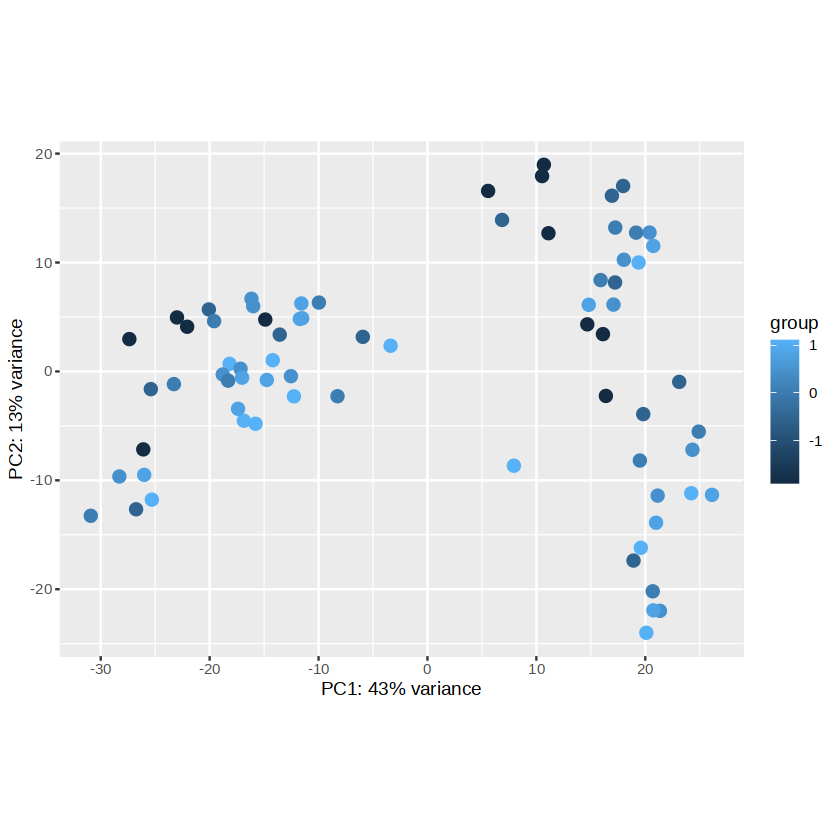

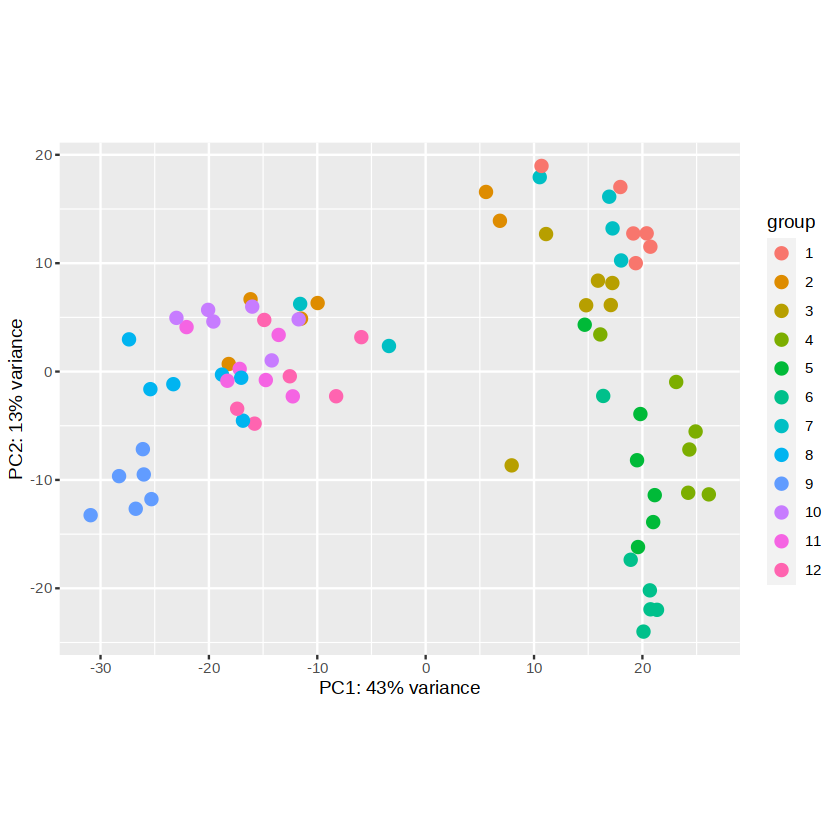

In [20]:
plotPCA(vsd_orig,intgroup=c('t_int'))
plotPCA(vsd_orig,intgroup=c('sample'))


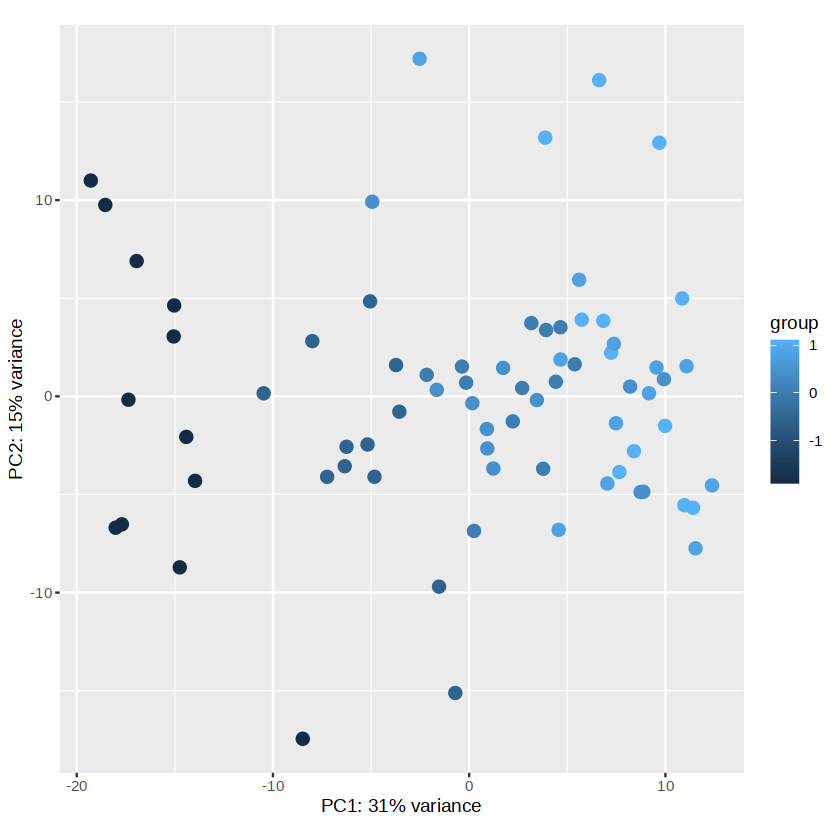

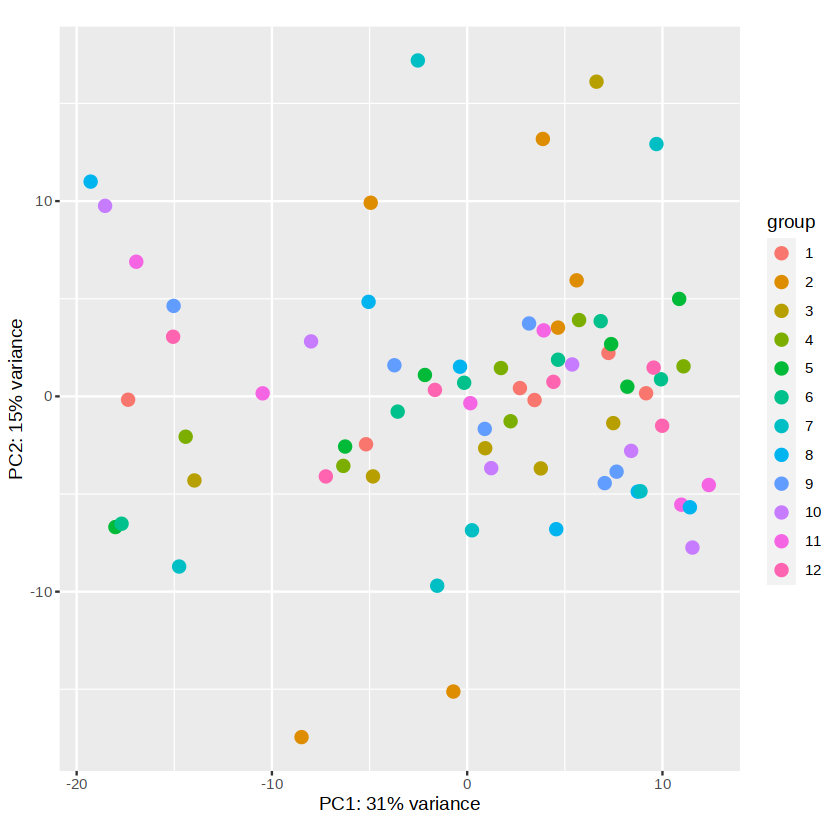

In [21]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~t_int, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$sample, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_samplecorr <- vsd_bk

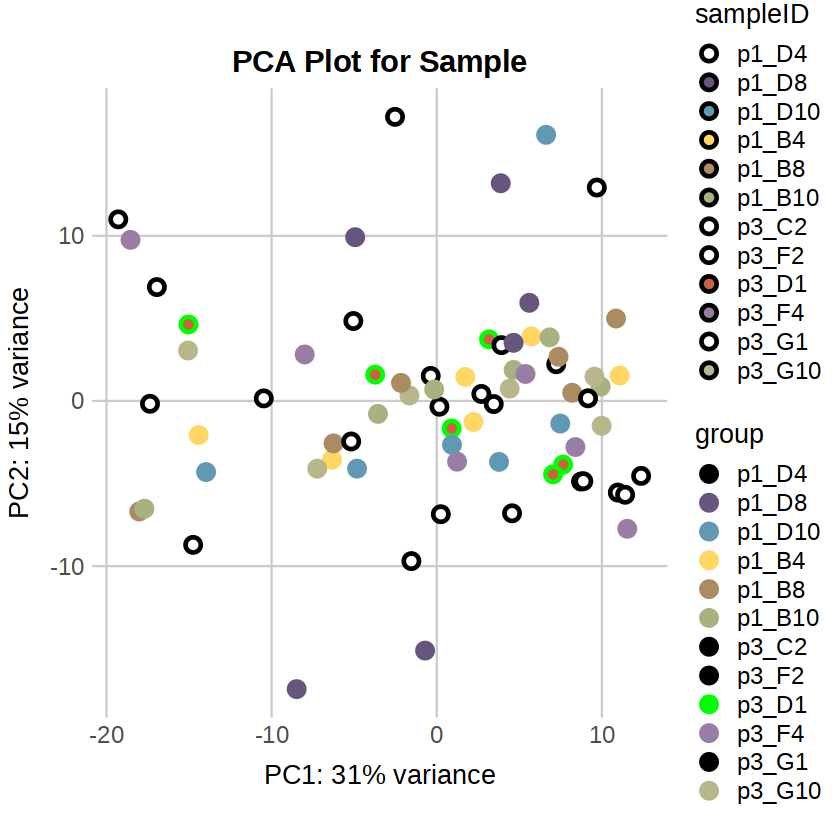

In [23]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)


outline_color_map <- c(
  'p1_D4' = 'black',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = 'black',
  'p3_F2' = 'black',
  'p3_D1' = 'green',
  'p3_F4' = '#9a7da7',
  'p3_G1' = 'black',
  'p3_G10' = '#b8b78b'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_samplecorr$sampleID <- factor(sample2ID[as.character(vsd_samplecorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_samplecorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 1.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample.pdf", plot = p_sample, width = 8, height = 6)


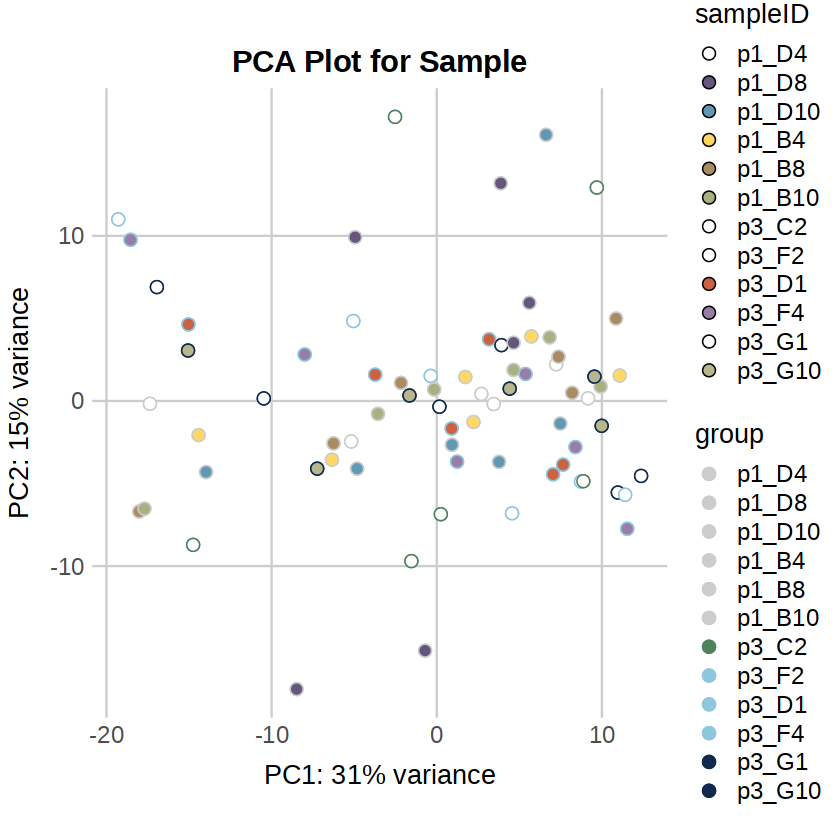

In [25]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)

outline_color_map <- c(
  'p1_D4' = '#CBCCCC',
  'p1_D8' = '#CBCCCC',
  'p1_D10' = '#CBCCCC',
  'p1_B4' = '#CBCCCC',
  'p1_B8' = '#CBCCCC',
  'p1_B10' = '#CBCCCC',
  'p3_C2' = '#4E835E',
  'p3_F2' = '#8DC7DD',
  'p3_D1' = '#8DC7DD',
  'p3_F4' = '#8DC7DD',
  'p3_G1' = '#102A4D',
  'p3_G10' = '#102A4D'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_samplecorr$sampleID <- factor(sample2ID[as.character(vsd_samplecorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_samplecorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 0.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample.pdf", plot = p_sample, width = 8, height = 6)


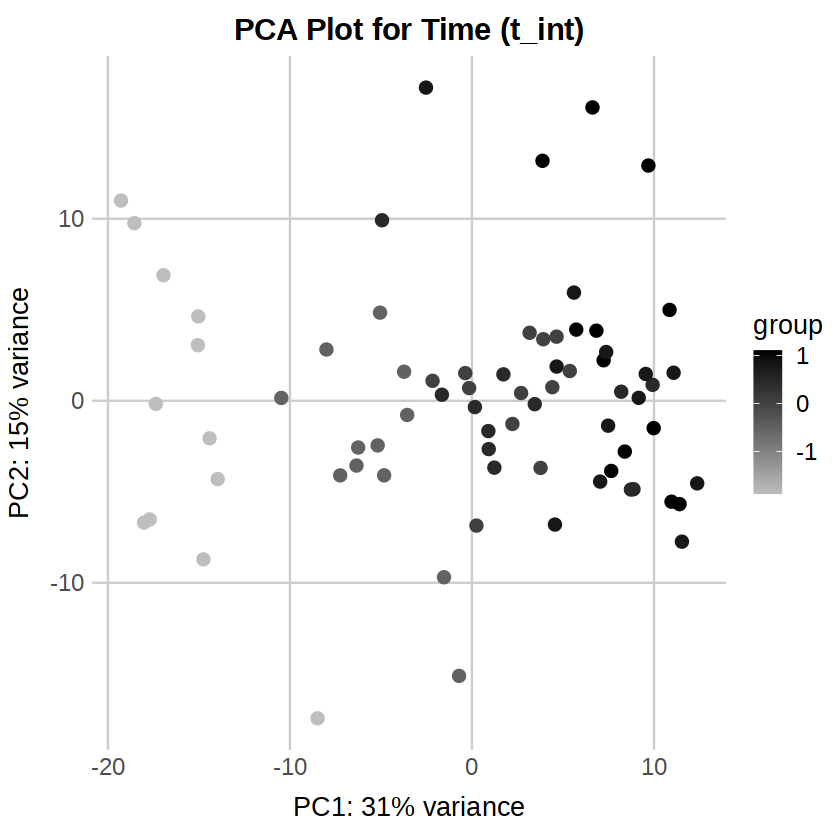

In [27]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Create the PCA plot for 't_int' as a continuous variable
p_t_int <- plotPCA(object = vsd_samplecorr, intgroup = c('t_int')) +
  ggtitle('PCA Plot for Time (t_int)') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  scale_color_gradient(low = "grey", high = "black")  # Gradient from black to white

# Display the 't_int' plot in the notebook
print(p_t_int)

# Save the 't_int' plot as a PDF file
ggsave("stability_plots/PCA_Plot_t_int.pdf", plot = p_t_int, width = 8, height = 6)


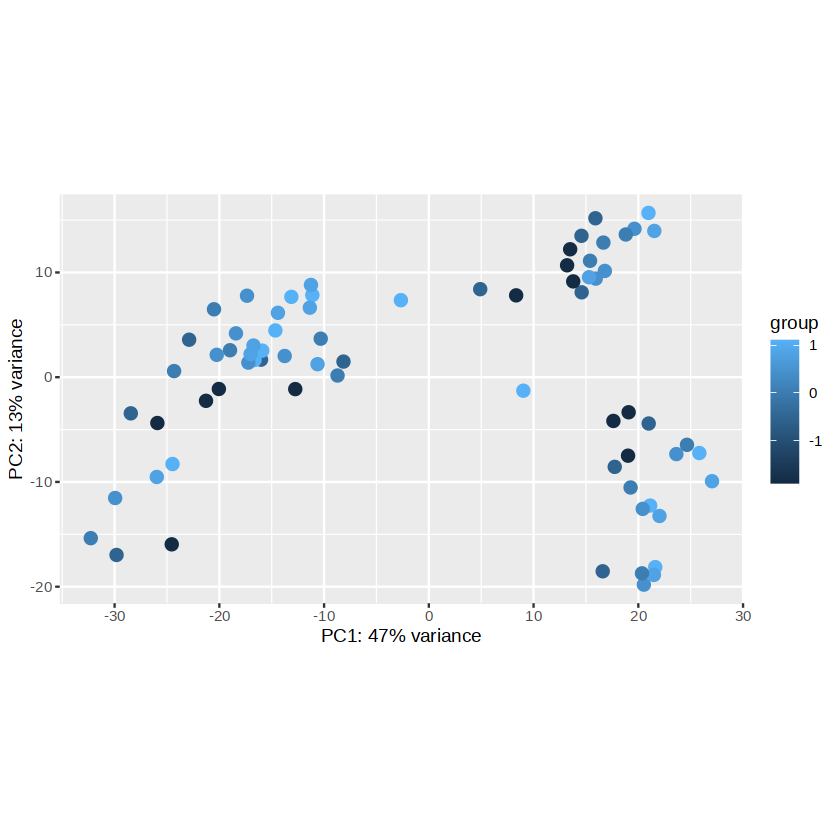

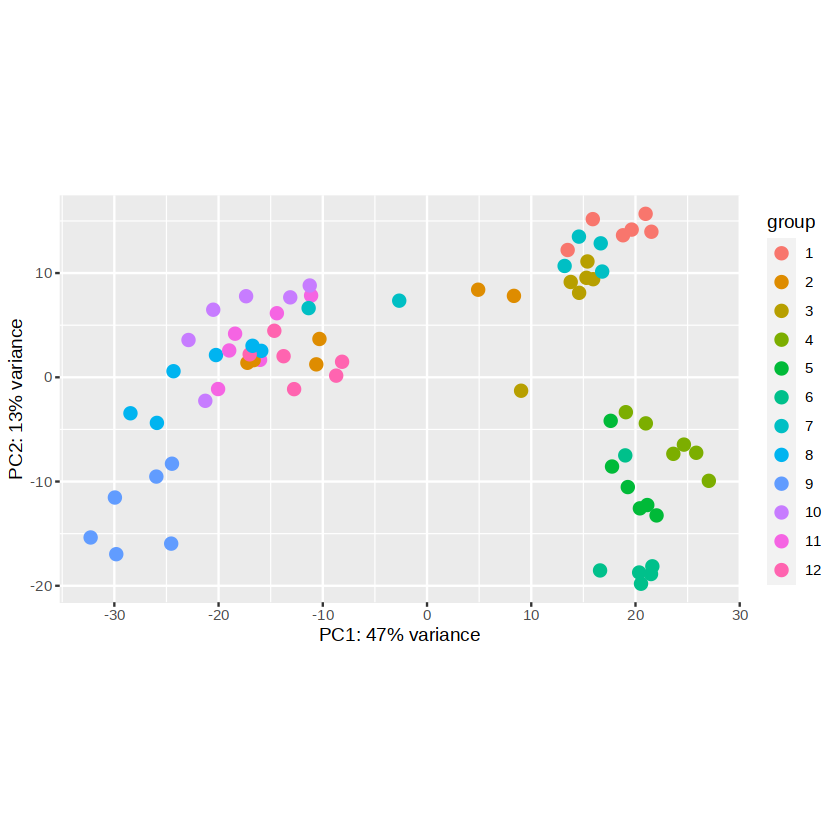

In [28]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~sample, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$t_int, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_tcorr <- vsd_bk

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



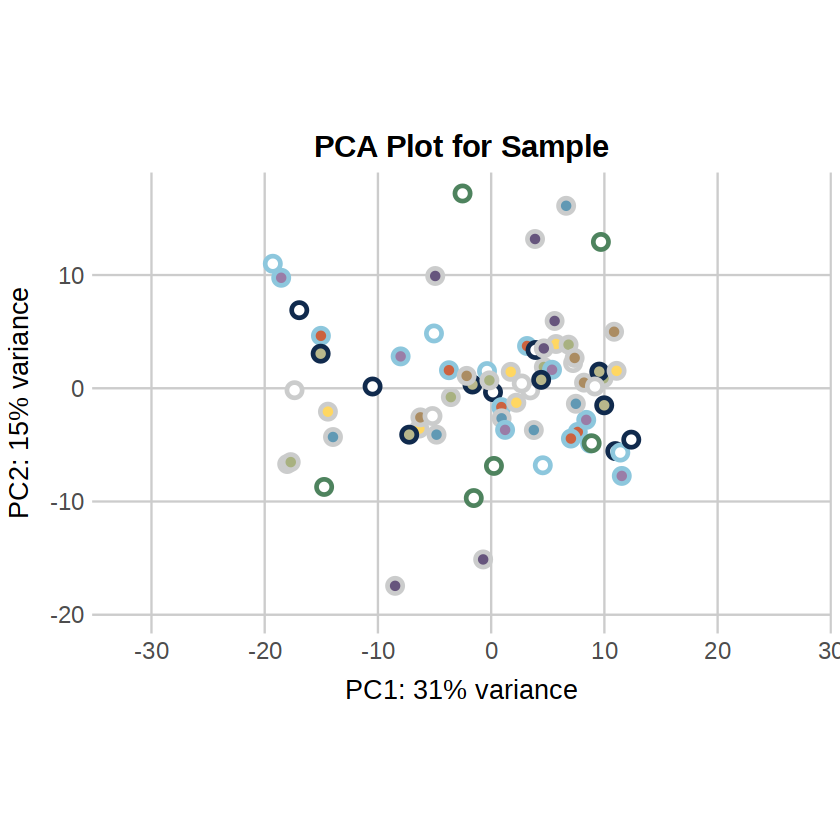

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



ERROR: Error in xlim(xlim): argument "xlim" is missing, with no default


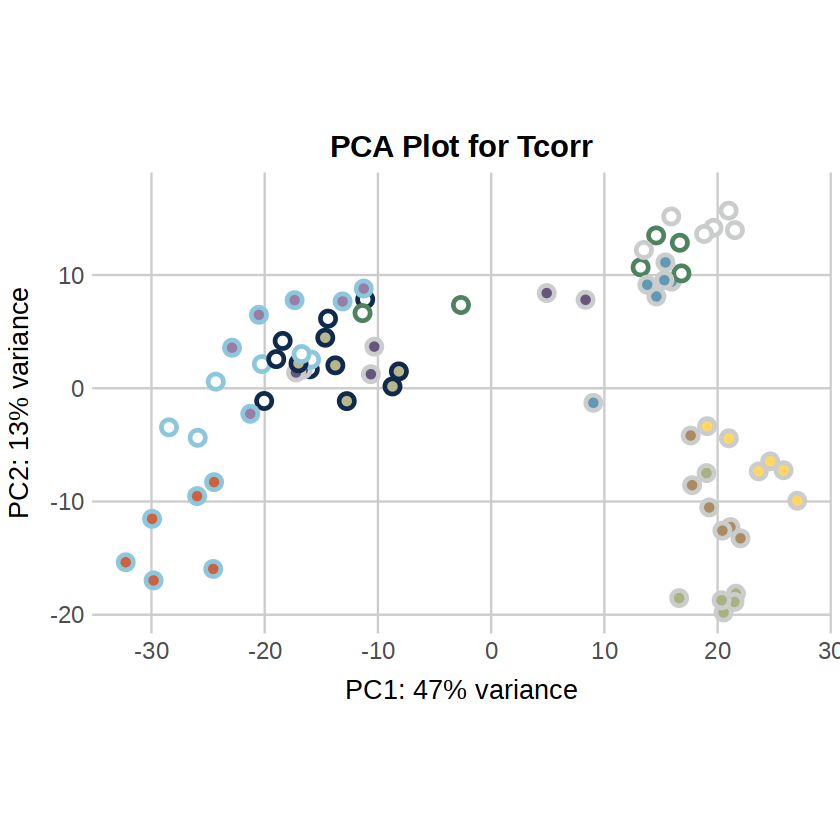

In [37]:
# Calculate the x and y limits based on both datasets
get_pca_limits <- function(vsd_object) {
  pca_data <- plotPCA(vsd_object, intgroup = c('sampleID'), returnData = TRUE)
  xlim <- range(pca_data$PC1)
  ylim <- range(pca_data$PC2)
  return(list(xlim = xlim, ylim = ylim))
}

# Calculate limits for both datasets
limits_samplecorr <- get_pca_limits(vsd_samplecorr)
limits_tcorr <- get_pca_limits(vsd_tcorr)

# Determine overall limits by taking the range across both datasets
overall_xlim <- range(limits_samplecorr$xlim, limits_tcorr$xlim)
overall_ylim <- range(limits_samplecorr$ylim, limits_tcorr$ylim)

# Create a function to ensure consistency
create_pca_plot <- function(vsd_object, title, fill_color_map, outline_color_map, filename, xlim, ylim) {
  
  # Map 'sample' numbers to their corresponding IDs (adjust this mapping if necessary)
  vsd_object$sampleID <- factor(sample2ID[as.character(vsd_object$sample)], levels = names(fill_color_map))
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c('sampleID')) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank(),
      legend.position = "none"  # Remove the legend
    ) +
    geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 1.5) +
    scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
    scale_color_manual(values = outline_color_map) +  # Apply custom outline colors
    coord_fixed() +  # Ensures equal scaling for x and y axes
    xlim(xlim) +  # Apply common x limits
    ylim(ylim)    # Apply common y limits
  
  # Display the plot
  print(p)
  
  # Save the plot with consistent dimensions
  ggsave(filename, plot = p, width = 8, height = 6)
}

# Create PCA plots for vsd_samplecorr and vsd_tcorr with consistent settings
create_pca_plot(vsd_samplecorr, "PCA Plot for Sample", fill_color_map, outline_color_map, "stability_plots/PCA_Plot_samplecorr_test.pdf",overall_xlim, overall_ylim)

create_pca_plot(vsd_tcorr, "PCA Plot for Tcorr", fill_color_map, outline_color_map, "stability_plots/PCA_Plot_tcorr.pdf", overall_xlim, overall_ylim)


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



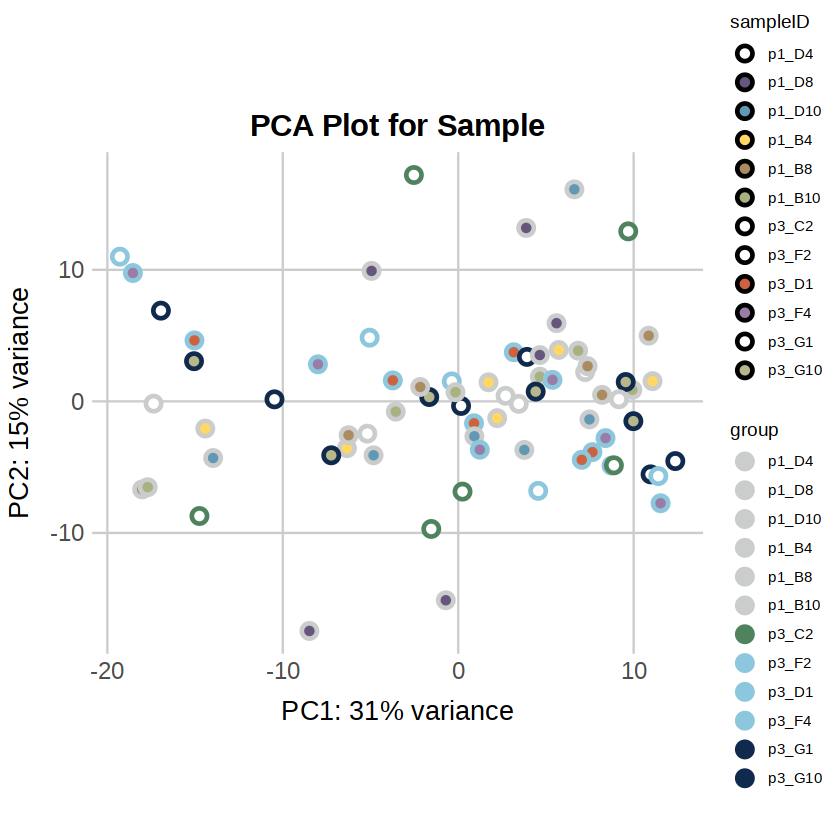

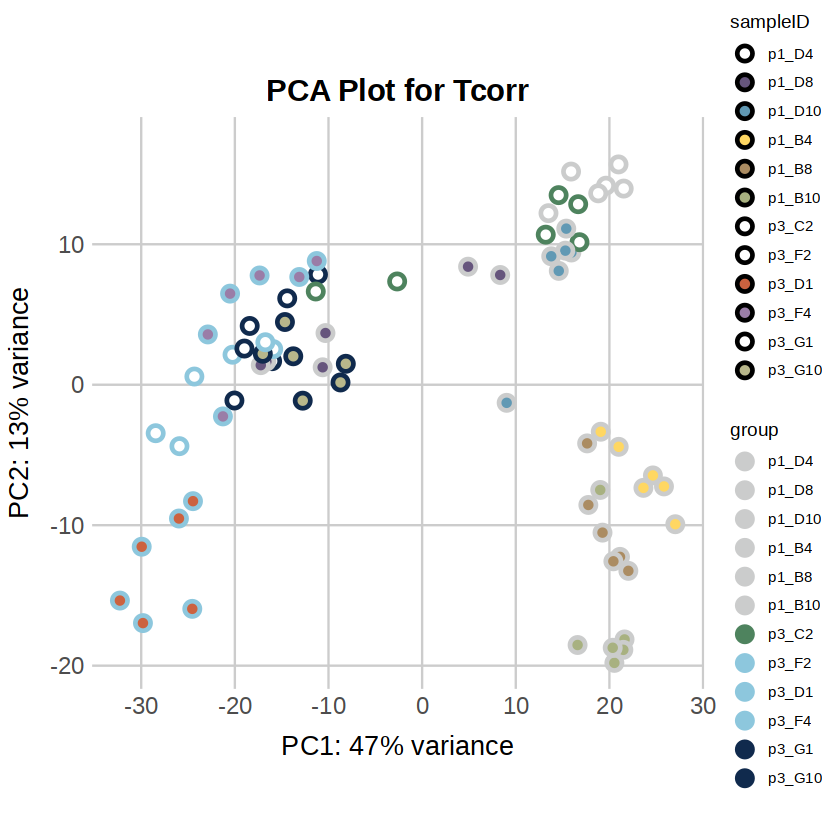

In [48]:
create_pca_plot <- function(
  vsd_object, 
  title, 
  plot_var,  # The variable to plot, e.g., sampleID
  filename, 
  fill_color_map = NULL,  # Optional: Fill color map
  outline_color_map = NULL,  # Optional: Outline color map
  xlim = NULL,  # Optional: X-axis limits
  ylim = NULL,  # Optional: Y-axis limits
  aspect_ratio = 1,  # Optional: Aspect ratio (default is 1:1)
  remove_legend = FALSE,  # Optional: Remove legend (default is FALSE)
  width = 8,  # Optional: Width of the saved plot
  height = 6  # Optional: Height of the saved plot
) {
  
  # Map 'plot_var' to factor levels if applicable
  vsd_object[[plot_var]] <- factor(vsd_object[[plot_var]])
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c(plot_var)) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank()
    ) +
    geom_point(aes(color = !!sym(plot_var), fill = !!sym(plot_var)), size = 3, shape = 21, stroke = 1.5) +
    coord_fixed(ratio = aspect_ratio)  # Set aspect ratio
  
  # Apply custom fill colors if provided
  if (!is.null(fill_color_map)) {
    p <- p + scale_fill_manual(values = fill_color_map)
  }
  
  # Apply custom outline colors if provided
  if (!is.null(outline_color_map)) {
    p <- p + scale_color_manual(values = outline_color_map)
  }
  
  # Apply common x limits if provided
  if (!is.null(xlim)) {
    p <- p + xlim(xlim)
  }
  
  # Apply common y limits if provided
  if (!is.null(ylim)) {
    p <- p + ylim(ylim)
  }
  
  # Remove the legend if specified
  if (remove_legend) {
    p <- p + theme(legend.position = "none")
  }
  
  # Display the plot
  print(p)
  
  # Save the plot with the specified dimensions
  ggsave(filename, plot = p, width = width, height = height)
}

# Example usage without custom colors and limits, with legend removed
create_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for Sample", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_sample.pdf",
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = FALSE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with custom colors, limits, aspect ratio, and legend included
create_pca_plot(
  vsd_tcorr, 
  "PCA Plot for Tcorr", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_tcorr.pdf", 
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = FALSE,  # Keep legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



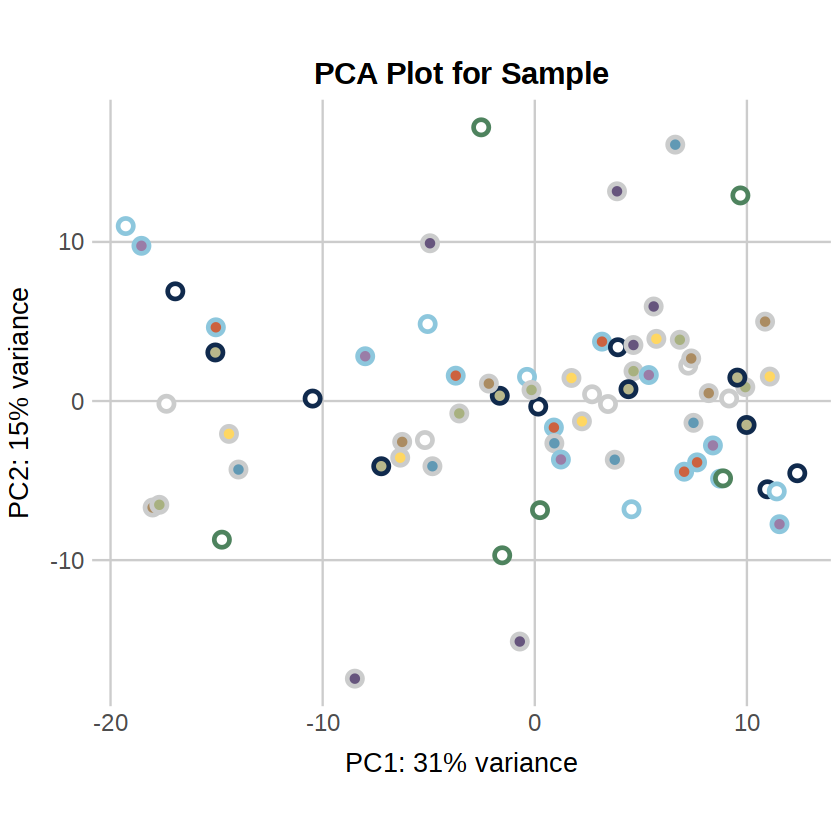

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



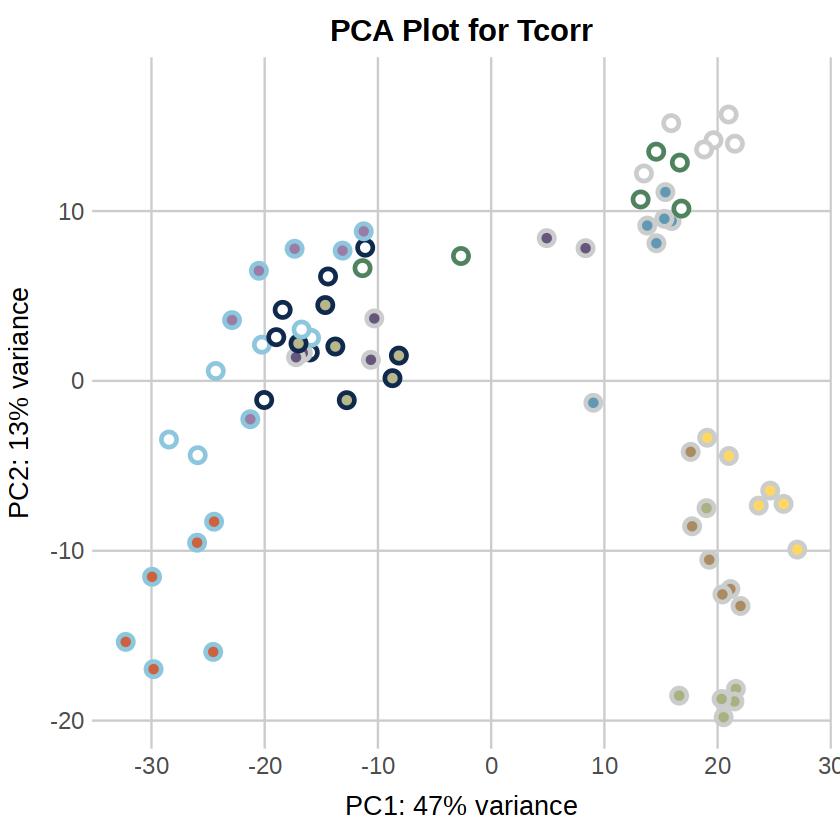

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



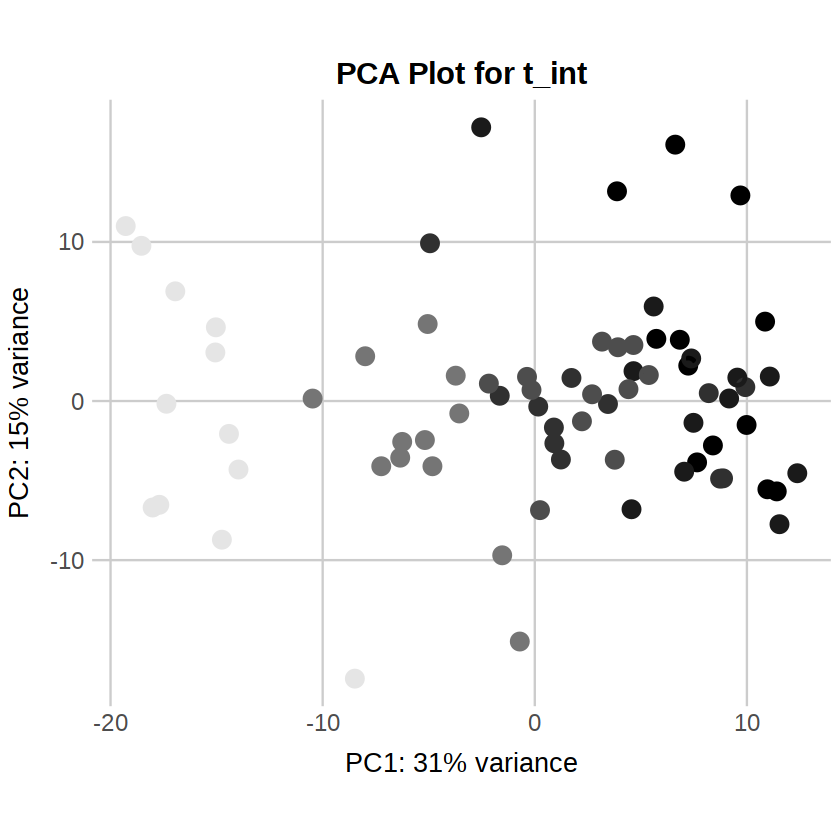

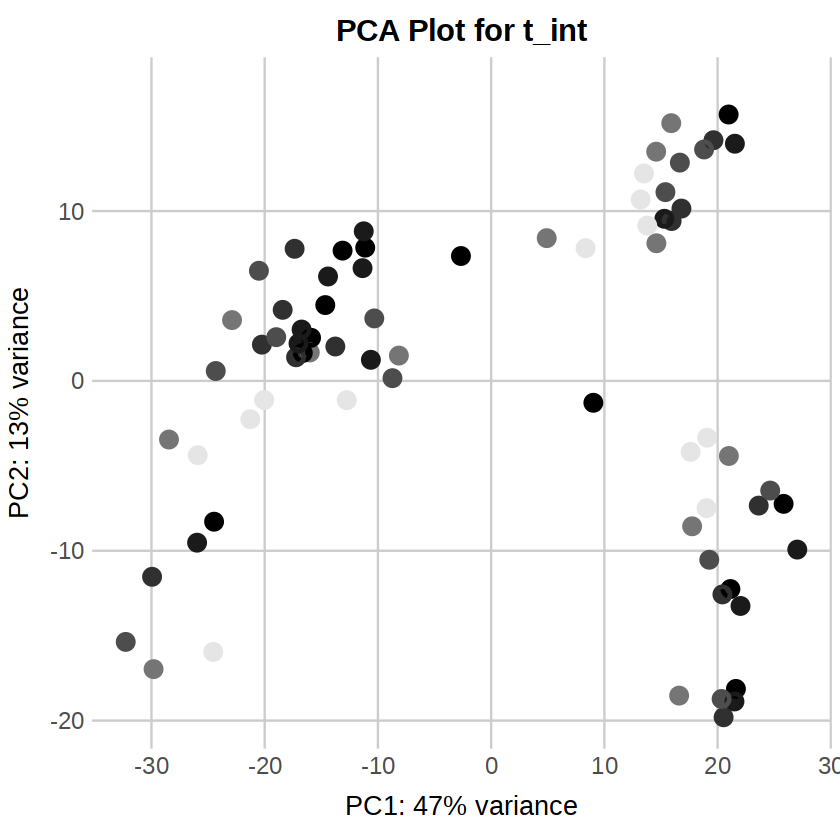

In [54]:
quantitative_pca_plot <- function(
  vsd_object, 
  title, 
  plot_var,  # The continuous variable to plot, e.g., t_int
  filename, 
  color_map = scale_color_gradient(low = "gray90", high = "black"),  # Default: grayscale from gray to black
  xlim = NULL,  # Optional: X-axis limits
  ylim = NULL,  # Optional: Y-axis limits
  aspect_ratio = 1,  # Optional: Aspect ratio (default is 1:1)
  remove_legend = FALSE,  # Optional: Remove legend (default is FALSE)
  width = 8,  # Optional: Width of the saved plot
  height = 6  # Optional: Height of the saved plot
) {
  
  # Ensure that plot_var is treated as a numeric variable
  vsd_object[[plot_var]] <- as.numeric(vsd_object[[plot_var]])
  
  # Generate the PCA plot
  p <- plotPCA(object = vsd_object, intgroup = c(plot_var)) +
    ggtitle(title) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title.x = element_text(size = 16, margin = margin(t = 10)),
      axis.title.y = element_text(size = 16, margin = margin(r = 10)),
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      panel.grid.major = element_line(color = "gray80"),
      panel.grid.minor = element_blank()
    ) +
    geom_point(aes(color = !!sym(plot_var)), size = 3, shape = 21, stroke = 1.5) +
    coord_fixed(ratio = aspect_ratio)  # Set aspect ratio
  
  # Apply custom color map
  p <- p + color_map
  
  # Apply common x limits if provided
  if (!is.null(xlim)) {
    p <- p + xlim(xlim)
  }
  
  # Apply common y limits if provided
  if (!is.null(ylim)) {
    p <- p + ylim(ylim)
  }
  
  # Remove the legend if specified
  if (remove_legend) {
    p <- p + theme(legend.position = "none")
  }
  
  # Display the plot
  print(p)
  
  # Save the plot with the specified dimensions
  ggsave(filename, plot = p, width = width, height = height)
}


# Example usage without custom colors and limits, with legend removed
create_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for Sample", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_sample.pdf",
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with custom colors, limits, aspect ratio, and legend included
create_pca_plot(
  vsd_tcorr, 
  "PCA Plot for Tcorr", 
  plot_var = "sampleID", 
  filename = "stability_plots/PCA_Plot_tcorr.pdf", 
  fill_color_map = fill_color_map, 
  outline_color_map = outline_color_map, 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = TRUE,  # Keep legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


# Example usage with default grayscale color map
quantitative_pca_plot(
  vsd_samplecorr, 
  "PCA Plot for t_int", 
  plot_var = "t_int", 
  filename = "stability_plots/PCA_Plot_t_int.pdf",
  aspect_ratio = 0.75,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)

# Example usage with a custom color gradient and legend removed
quantitative_pca_plot(
  vsd_tcorr, 
  "PCA Plot for t_int", 
  plot_var = "t_int", 
  filename = "stability_plots/PCA_Plot_t_int_custom.pdf", 
  xlim = overall_xlim, 
  ylim = overall_ylim, 
  aspect_ratio = 1.5,  # Custom aspect ratio
  remove_legend = TRUE,  # Remove legend
  width = 6,  # Custom width
  height = 6  # Custom height
)


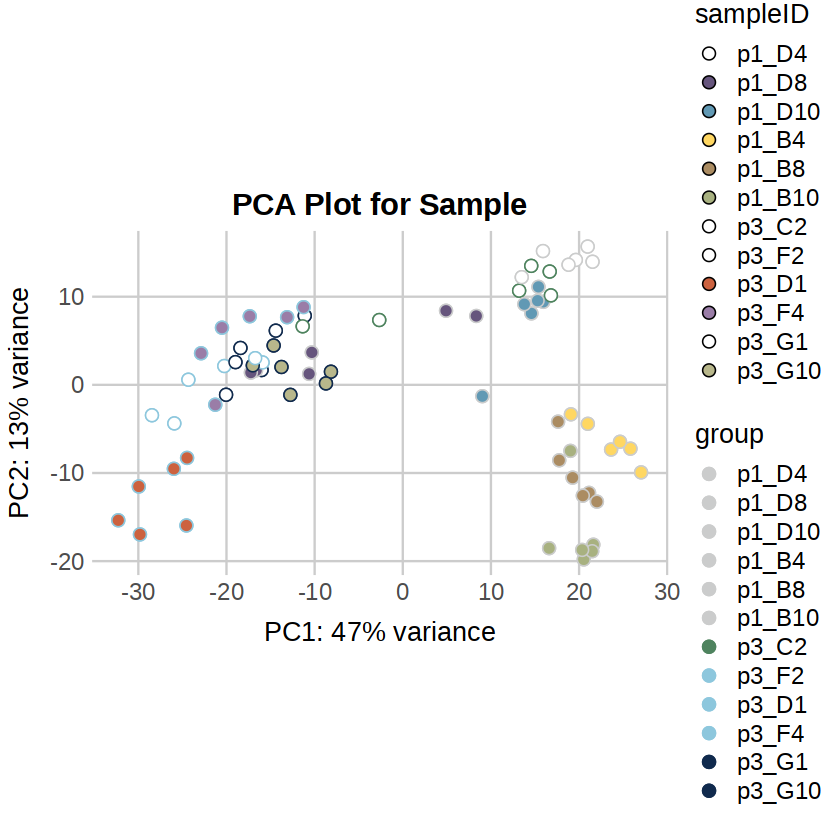

In [29]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Step 1: Define sample to ID mapping and two color mappings
sample2ID <- c(
  '1' = 'p1_D4',
  '2' = 'p1_D8',
  '3' = 'p1_D10',
  '4' = 'p1_B4',
  '5' = 'p1_B8',
  '6' = 'p1_B10',
  '7' = 'p3_C2',
  '8' = 'p3_F2',
  '9' = 'p3_D1',
  '10' = 'p3_F4',
  '11' = 'p3_G1',
  '12' = 'p3_G10'
)

fill_color_map <- c(
  'p1_D4' = '#ffffff',
  'p1_D8' = '#66557d',
  'p1_D10' = '#6199b4',
  'p1_B4' = '#ffd762',
  'p1_B8' = '#ab8c62',
  'p1_B10' = '#a8b180',
  'p3_C2' = '#ffffff',
  'p3_F2' = '#ffffff',
  'p3_D1' = '#cc623f',
  'p3_F4' = '#9a7da7',
  'p3_G1' = '#ffffff',
  'p3_G10' = '#b8b78b'
)

outline_color_map <- c(
  'p1_D4' = '#CBCCCC',
  'p1_D8' = '#CBCCCC',
  'p1_D10' = '#CBCCCC',
  'p1_B4' = '#CBCCCC',
  'p1_B8' = '#CBCCCC',
  'p1_B10' = '#CBCCCC',
  'p3_C2' = '#4E835E',
  'p3_F2' = '#8DC7DD',
  'p3_D1' = '#8DC7DD',
  'p3_F4' = '#8DC7DD',
  'p3_G1' = '#102A4D',
  'p3_G10' = '#102A4D'
)

# Step 2: Map 'sample' numbers to their corresponding IDs
vsd_tcorr$sampleID <- factor(sample2ID[as.character(vsd_tcorr$sample)], levels = names(fill_color_map))

# Create the PCA plot for 'sample' with custom fill and outline colors
p_sample <- plotPCA(object = vsd_tcorr, intgroup = c('sampleID')) +
  ggtitle('PCA Plot for Sample') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  geom_point(aes(color = sampleID, fill = sampleID), size = 3, shape = 21, stroke = 0.5) +
  scale_fill_manual(values = fill_color_map) +  # Apply custom fill colors
  scale_color_manual(values = outline_color_map)  # Apply custom outline colors

# Display the 'sample' plot in the notebook
print(p_sample)

# Save the 'sample' plot as a PDF file
ggsave("stability_plots/PCA_Plot_sample_tcorr.pdf", plot = p_sample, width = 8, height = 6)


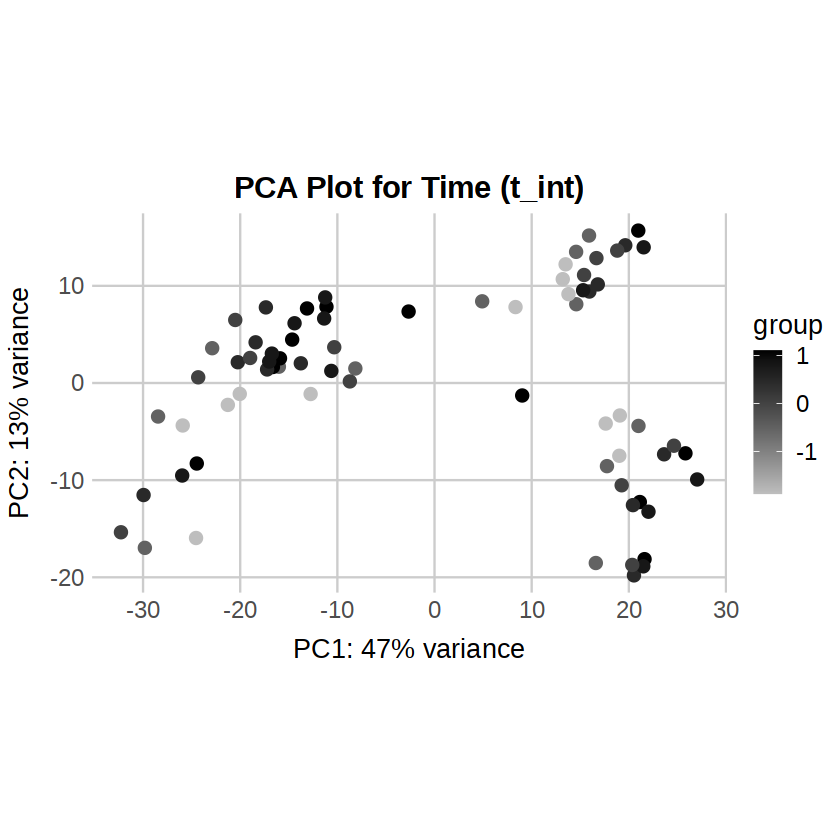

In [30]:
# Load necessary libraries
library(ggplot2)
library(DESeq2)  # Assuming you're using DESeq2 for vsd_samplecorr

# Create the PCA plot for 't_int' as a continuous variable
p_t_int <- plotPCA(object = vsd_tcorr, intgroup = c('t_int')) +
  ggtitle('PCA Plot for Time (t_int)') +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
    axis.title.x = element_text(size = 16, margin = margin(t = 10)),
    axis.title.y = element_text(size = 16, margin = margin(r = 10)),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_line(color = "gray80"),
    panel.grid.minor = element_blank()
  ) +
  scale_color_gradient(low = "grey", high = "black")  # Gradient from black to white

# Display the 't_int' plot in the notebook
print(p_t_int)

# Save the 't_int' plot as a PDF file
ggsave("stability_plots/PCA_Plot_t_int_tcorr.pdf", plot = p_t_int, width = 8, height = 6)


In [19]:
# Assuming pca_df is your data frame and 'object' is the PCA object used for plotting

# Function to create a PCA plot for a given variable
plotPCA_custom <- function(pca_df, variable) {
  plotPCA(object = pca_df, intgroup = c(variable)) +
    ggtitle(paste('PCA Plot for', variable))
}

# List of variables to plot
variables <- c('M_BMP4', 'M_SHH', 'M_RA', 'M_CHIR', 'M_XAV', 'M_FGF8')

# Set plot size
options(repr.plot.width=15, repr.plot.height=10)

# Generate a list of PCA plots
plots <- lapply(variables, function(var) plotPCA_custom(vsd, var))

# Arrange the plots in a grid (2 rows, 3 columns)
grid.arrange(grobs = plots, ncol = 3)


ERROR: Error in .local(object, ...): the argument 'intgroup' should specify columns of colData(dds)


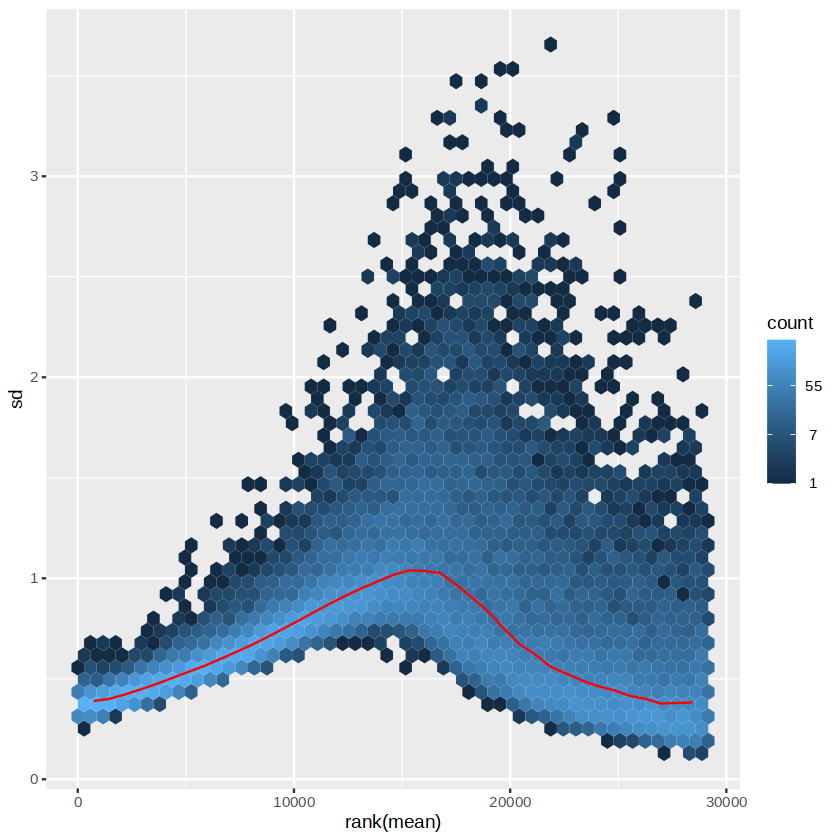

In [31]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd)) 

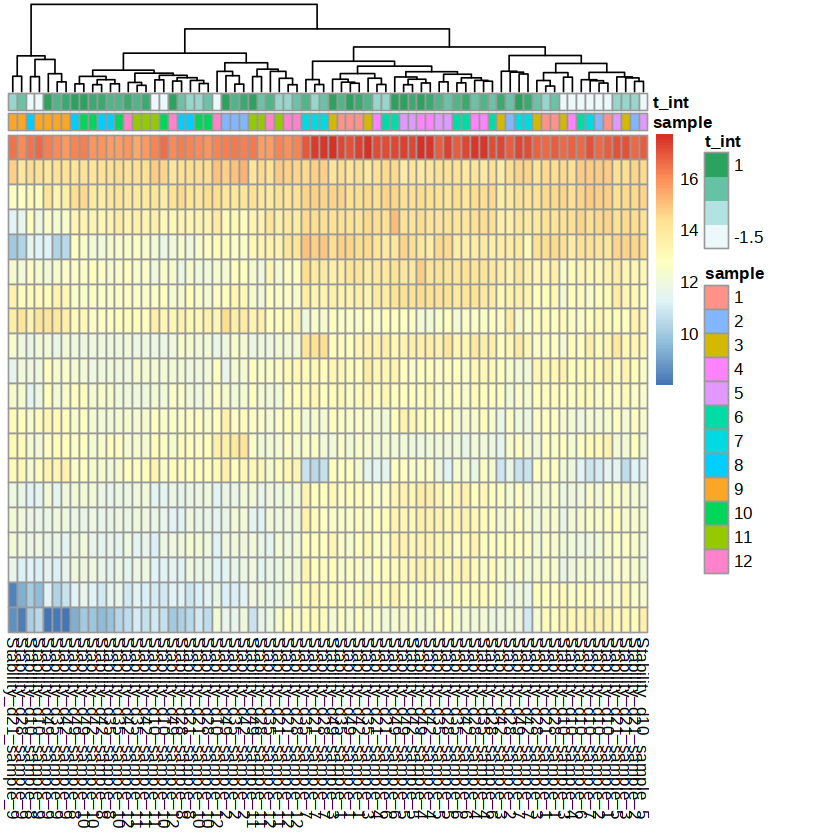

In [32]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("sample","t_int")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

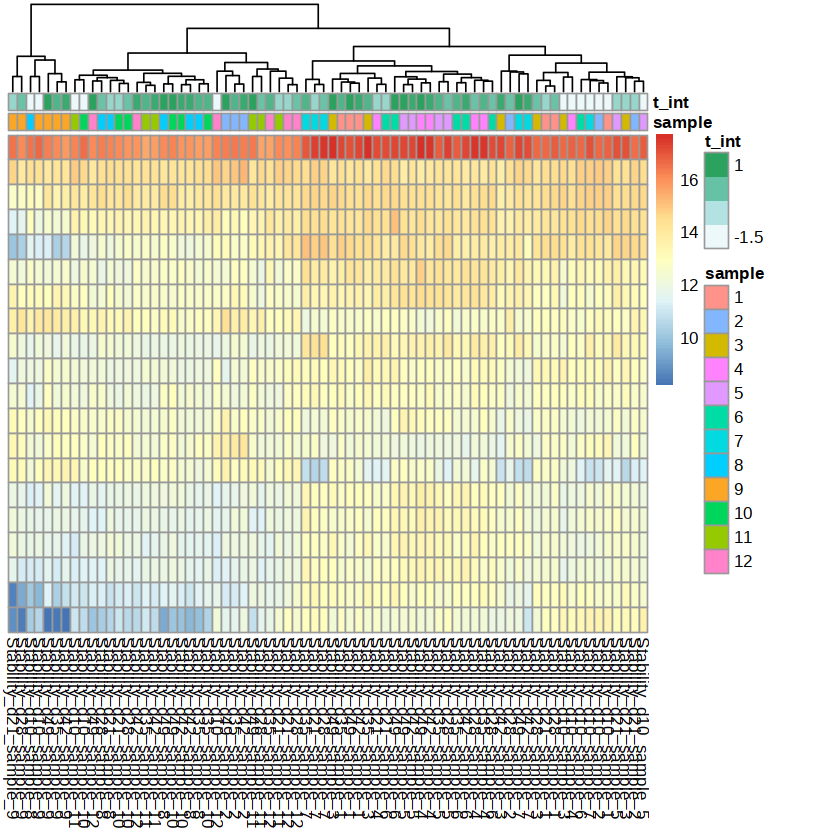

In [33]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("sample","t_int")])
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

In [23]:
# Assuming you have already created the DESeqDataSet object `dds`
# Normalize and transform the data
vsd <- vst(dds, blind = FALSE)

# Extract the transformed counts
transformed_counts <- assay(vsd)

# Get the sample information
sample_info <- colData(vsd)

# Compute Euclidean distances
euclidean_distance <- function(x, y) {
  sqrt(sum((x - y)^2))
}

# Calculate distances between matching conditions
matching_distances <- sapply(1:82, function(i) {
  sample1 <- transformed_counts[, sample_info$batch == "Batch1" & sample_info$condition == paste0("Condition", i)]
  sample2 <- transformed_counts[, sample_info$batch == "Batch2" & sample_info$condition == paste0("Condition", i)]
  euclidean_distance(sample1, sample2)
})

# Calculate distances between random pairs of samples
set.seed(123) # For reproducibility
random_distances <- replicate(82, {
  random_sample1 <- transformed_counts[, sample(sample_info$sampleID, 1)]
  random_sample2 <- transformed_counts[, sample(sample_info$sampleID, 1)]
  euclidean_distance(random_sample1, random_sample2)
})

# Combine distances into a data frame
distances_df <- data.frame(
  Distance = c(matching_distances, random_distances),
  Type = rep(c("Matching", "Random"), each = 82)
)

# Plot the distances
ggplot(distances_df, aes(x = Type, y = Distance, fill = Type)) +
  geom_boxplot() +
  ggtitle("Comparison of Distances Between Matching and Random Samples") +
  ylab("Euclidean Distance") +
  theme_bw()


ERROR: Error in sample.int(length(x), size, replace, prob): invalid first argument


In [24]:
sampleDists <- dist(t(assay(vsd_orig)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_pca_distances_noFilter.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_samplecorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrS_pca_distances_noFilter.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_tcorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrT_pca_distances_noFilter.tsv",sep = "\t")


In [25]:
write.table(assay(vsd_orig),"bulk/stability_time_deseq2_vsd_noFilter.tsv",sep = "\t")
write.table(assay(vsd_samplecorr),"bulk/stability_time_deseq2_vsd_corrS_noFilter.tsv",sep = "\t")
write.table(assay(vsd_tcorr),"bulk/stability_time_deseq2_vsd_corrT_noFilter.tsv",sep = "\t")


Stability_d21_sample_4 Stability_d21_sample_5
5S_rRNA     4.707781               3.479777              
7SK         3.479777               3.479777              
A1BG        4.707781               4.388433              
A1BG-AS1    5.232599               4.803043              
A1CF        3.479777               3.891492              
A2M         4.884767               5.053099              
A2M-AS1     5.639698               4.857851              
A2ML1       3.479777               4.295110              
A2MP1       3.479777               3.479777              
A4GALT      5.549486               5.616097              
AAAS        6.906627               6.907729              
AACS        7.203102               7.430671              
AACSP1      4.963348               5.139428              
AADAT       5.878220               6.166024              
AAGAB       7.969775               8.241898              
AAK1        7.616155               7.859042              
AAMDC       4.884767               4.803043              
AAMP        8.981762               9.049218              
AANAT       3.479777               4.060087              
AAR2        7.936397               7.925834              
AARD        4.360805               4.388433              
AARS1       8.388947               8.367236              
AARS2       7.115974               7.407439              
AARSD1      3.993659               3.479777              
AARSD1P1    3.993659               3.479777              
AASDH       6.111633               5.963397              
AASDHPPT    9.586578               9.367688              
AASS        6.485204               6.088543              
AATBC       3.479777               4.188172              
AATF        6.080642               5.941369              
<U+22EE>      <U+22EE>               <U+22EE>              
ZSCAN29     6.200613               6.108328              
ZSCAN30     6.597570               6.499179              
ZSCAN31     4.360805               4.472021              
ZSCAN32     5.841321               5.985071              
ZSCAN5A     4.606112               4.909989              
ZSCAN5A-AS1 3.993659               3.891492              
ZSCAN5C     4.202774               5.671647              
ZSCAN9      7.054780               6.962108              
ZSWIM1      5.105726               5.053099              
ZSWIM2      3.479777               4.472021              
ZSWIM3      6.531237               5.801049              
ZSWIM4      3.479777               3.479777              
ZSWIM5      6.553698               6.203185              
ZSWIM5P2    3.479777               3.479777              
ZSWIM6      5.724073               5.497303              
ZSWIM7      7.495101               7.644348              
ZSWIM8      5.803376               5.671647              
ZSWIM9      4.202774               3.479777              
ZUP1        6.413181               6.705465              
ZW10        6.553698               6.653346              
ZWILCH      6.906627               7.302162              
ZWINT       6.363012               6.929731              
ZXDA        4.492087               4.857851              
ZXDB        5.170853               5.139428              
ZXDC        5.595376               4.803043              
ZYG11A      4.202774               3.479777              
ZYG11B      7.271852               7.702697              
ZYX         6.171588               5.873043              
ZZEF1       6.531237               6.221396              
ZZZ3        7.231001               7.268144              
            Stability_d21_sample_10 Stability_d21_sample_7
5S_rRNA     3.479777                3.479777              
7SK         3.479777                3.881889              
A1BG        4.319476                5.220857              
A1BG-AS1    4.319476                4.276445              
A1CF        3.479777                4.046638              
A2M         5.518409                7.884929              
A

In [32]:
vsd

class: DESeqTransform 
dim: 28587 61 
metadata(1): version
assays(1): ''
rownames(28587): 5S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(66): baseMean baseVar ... maxCooks dispFit
colnames(61): Stability_d21_sample_4 Stability_d21_sample_5 ...
  Stability_d28_sample_7 Stability_d28_sample_6
colData names(6): t sample ... sums sizeFactor

In [51]:
library(repr)



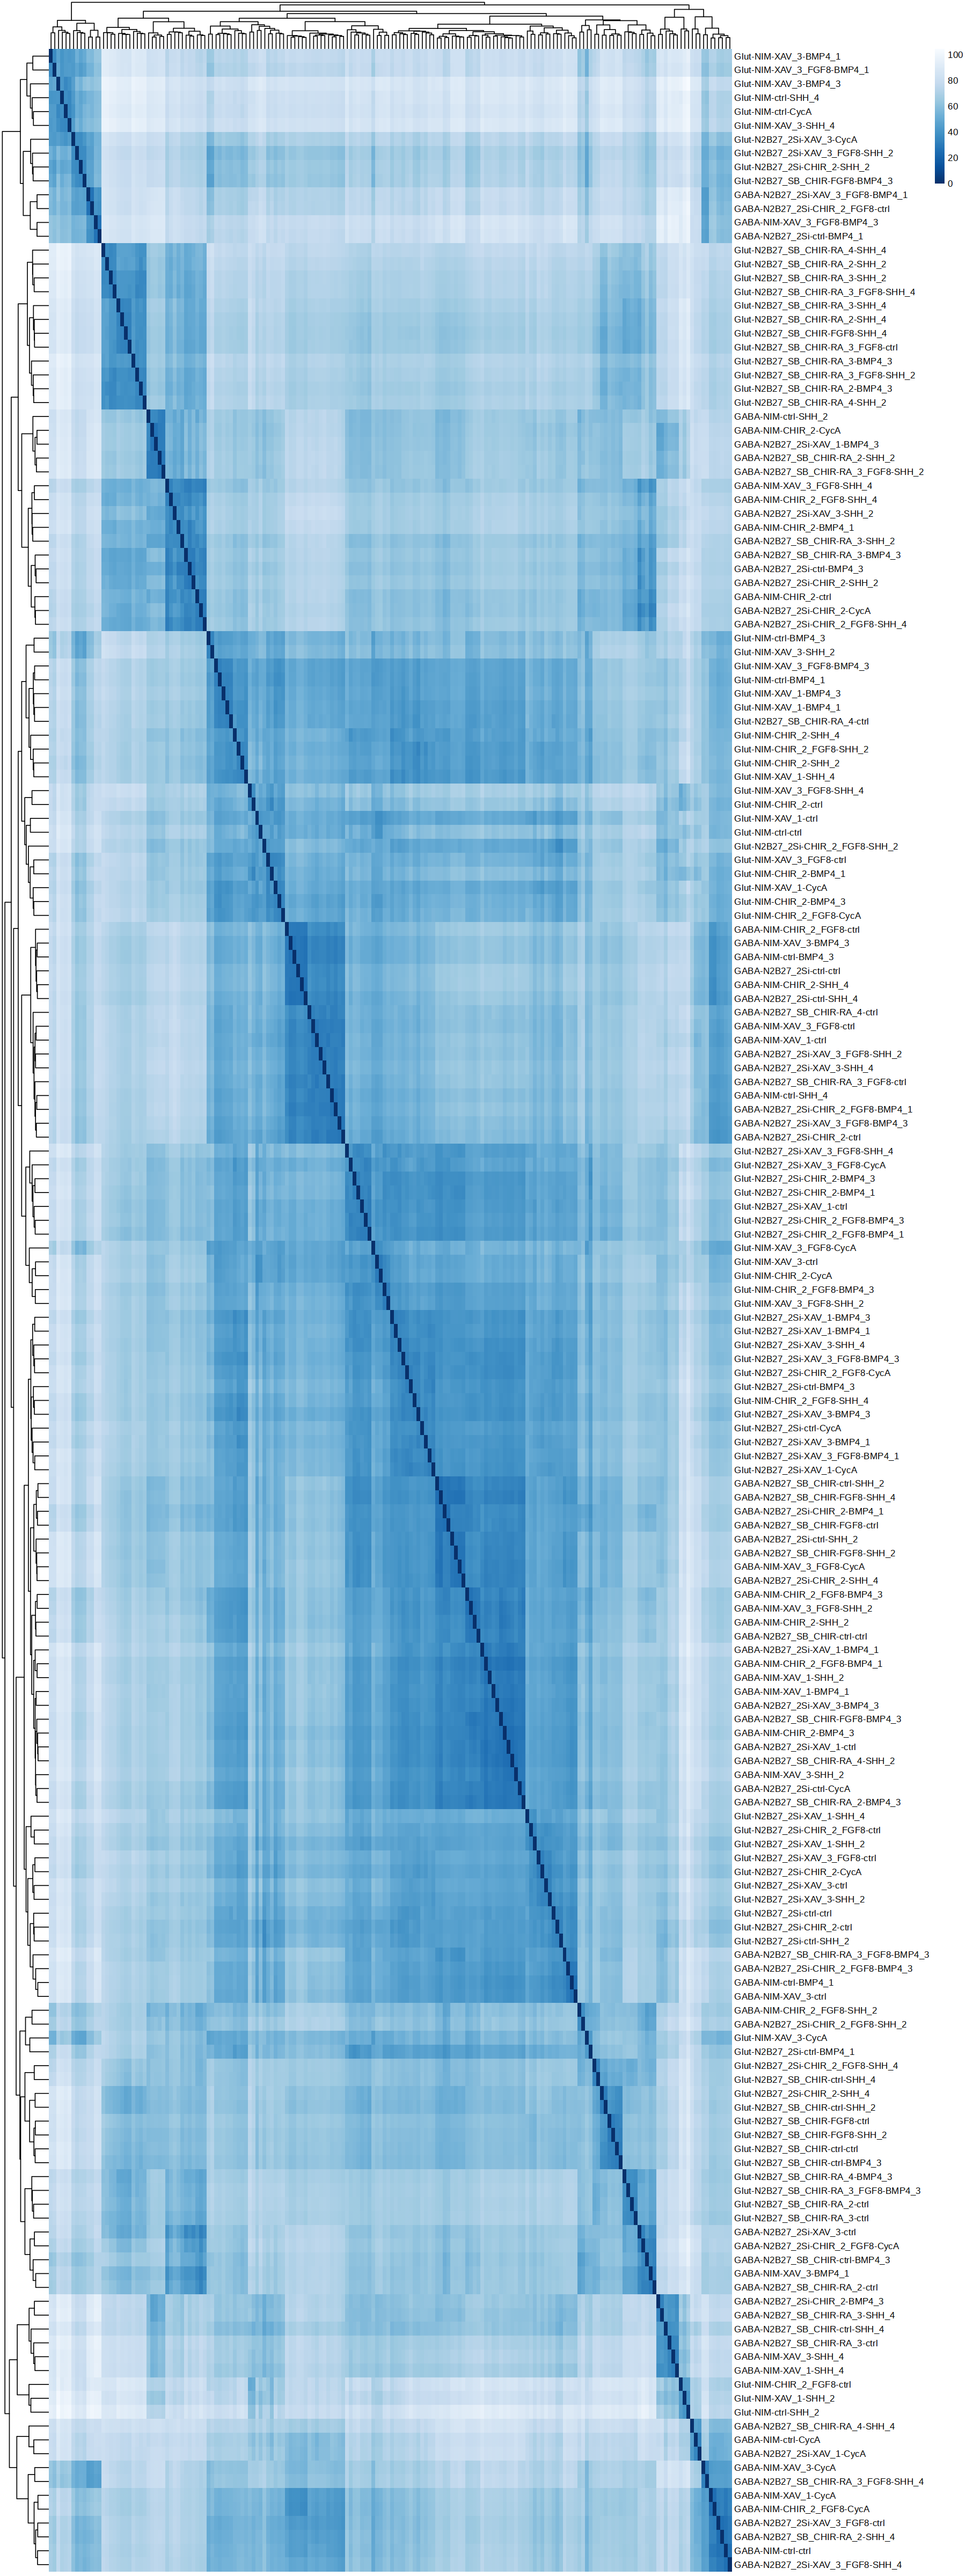

In [54]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(vsd$TF,vsd$Basal_media, vsd$AP_axis, vsd$DV_axis, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

# Set plot size
options(repr.plot.width=15, repr.plot.height=40)

pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [67]:
colnames(mm)

[1] "(Intercept)"              "M_RA"                    
[3] "M_XAV"                    "M_CHIR"                  
[5] "M_FGF8"                   "M_BMP4"                  
[7] "M_SHH"                    "Basal_mediaN2B27_SB_CHIR"
[9] "Basal_mediaNIM"

In [80]:
resAshT

log2 fold change (MMSE): M RA 
Wald test p-value: M RA 
DataFrame with 26046 rows and 5 columns
          baseMean log2FoldChange     lfcSE    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric>
A1BG     11.078487    0.000951472 0.0417937 0.9546671  0.983994
A1BG-AS1  3.003253   -0.022025185 0.0565259 0.1953668  0.495439
A1CF      0.314303    0.001924723 0.0674353 0.8393419        NA
A2M       4.446005    0.068560869 0.0942524 0.0159569  0.150561
A2M-AS1   3.967147   -0.006915710 0.0466550 0.6472442  0.843689
...            ...            ...       ...       ...       ...
ZYG11A     8.57726     0.02341255 0.0625491 0.1669396  0.462168
ZYG11B   115.37802    -0.00606248 0.0237642 0.7375706  0.887511
ZYX      175.03781     0.07047382 0.0834436 0.0128983  0.137026
ZZEF1     36.65814     0.00902080 0.0305574 0.6531622  0.847524
ZZZ3     302.21323    -0.02490163 0.0176660 0.0907511  0.350278

In [73]:
res_M_RA <- results(dds, name = "M_RA")
resAshT <- lfcShrink(dds,res=res_M_RA, coef=2, type="ashr", lfcThreshold=1)

In [102]:
cname <- "M_CHIR"
res_M_RA <- results(dds, name = cname)
resApe = lfcShrink(dds,res=res_M_RA,coef = cname,type="apeglm", lfcThreshold=1)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)



In [106]:
resApe

log2 fold change (MAP): M CHIR 
 
DataFrame with 26046 rows and 4 columns
          baseMean log2FoldChange      lfcSE    svalue
         <numeric>      <numeric>  <numeric> <numeric>
A1BG     11.078487   -0.000584181 0.00933743  0.938416
A1BG-AS1  3.003253   -0.000272153 0.00932950  0.939425
A1CF      0.314303    0.000120784 0.00934962  0.940402
A2M       4.446005    0.000619178 0.00934987  0.941348
A2M-AS1   3.967147    0.000363301 0.00933816  0.942265
...            ...            ...        ...       ...
ZYG11A     8.57726   -0.000542641 0.00935357  0.999858
ZYG11B   115.37802    0.000633110 0.00894191  0.999858
ZYX      175.03781   -0.002916402 0.00998571  0.999858
ZZEF1     36.65814   -0.002135274 0.00947873  0.999858
ZZZ3     302.21323    0.019338482 0.02287828  0.999858

In [105]:
res_M_RA

log2 fold change (MLE): M CHIR 
Wald test p-value: M CHIR 
DataFrame with 26046 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A1BG     11.078487     -0.0683902 0.0988031 -0.692187   0.488820  0.999957
A1BG-AS1  3.003253     -0.0736893 0.1245498 -0.591645   0.554088  0.999957
A1CF      0.314303      0.1309667 0.4568507  0.286673   0.774363  0.999957
A2M       4.446005      0.0165454 0.1159063  0.142748   0.886489  0.999957
A2M-AS1   3.967147      0.0780098 0.1346004  0.579566   0.562208  0.999957
...            ...            ...       ...       ...        ...       ...
ZYG11A     8.57726    -0.13051017 0.1459803 -0.894026 0.37130807  0.999957
ZYG11B   115.37802     0.00616459 0.0294312  0.209458 0.83409083  0.999957
ZYX      175.03781    -0.28521676 0.0926346 -3.078945 0.00207735  0.490978
ZZEF1     36.65814    -0.05092152 0.0434352 -1.172357 0.24105376  0.999957
Z

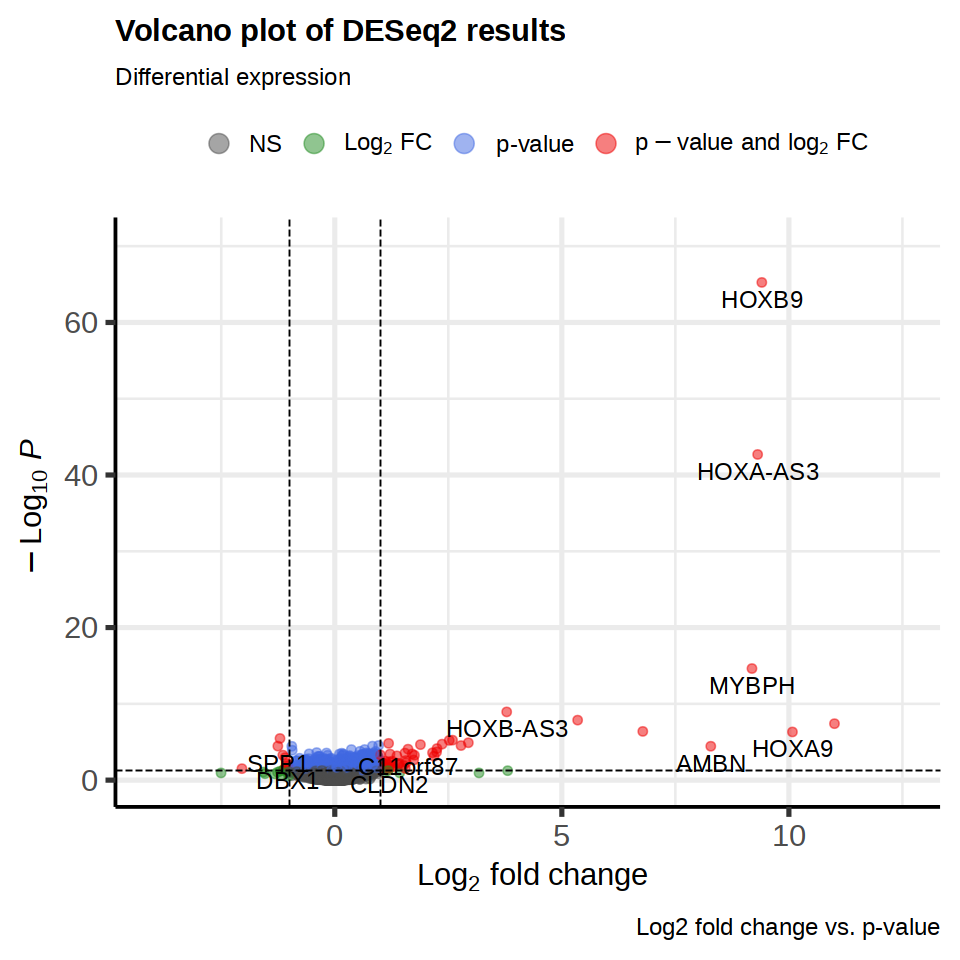

In [103]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



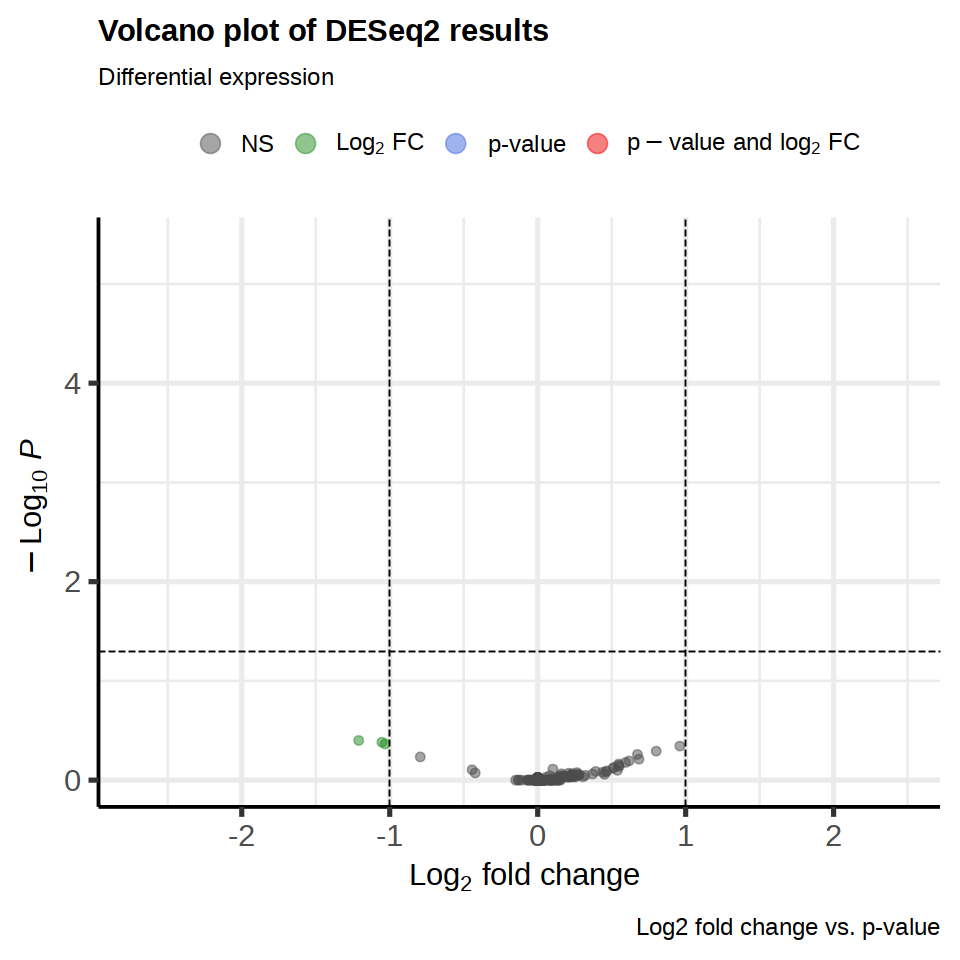

In [104]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



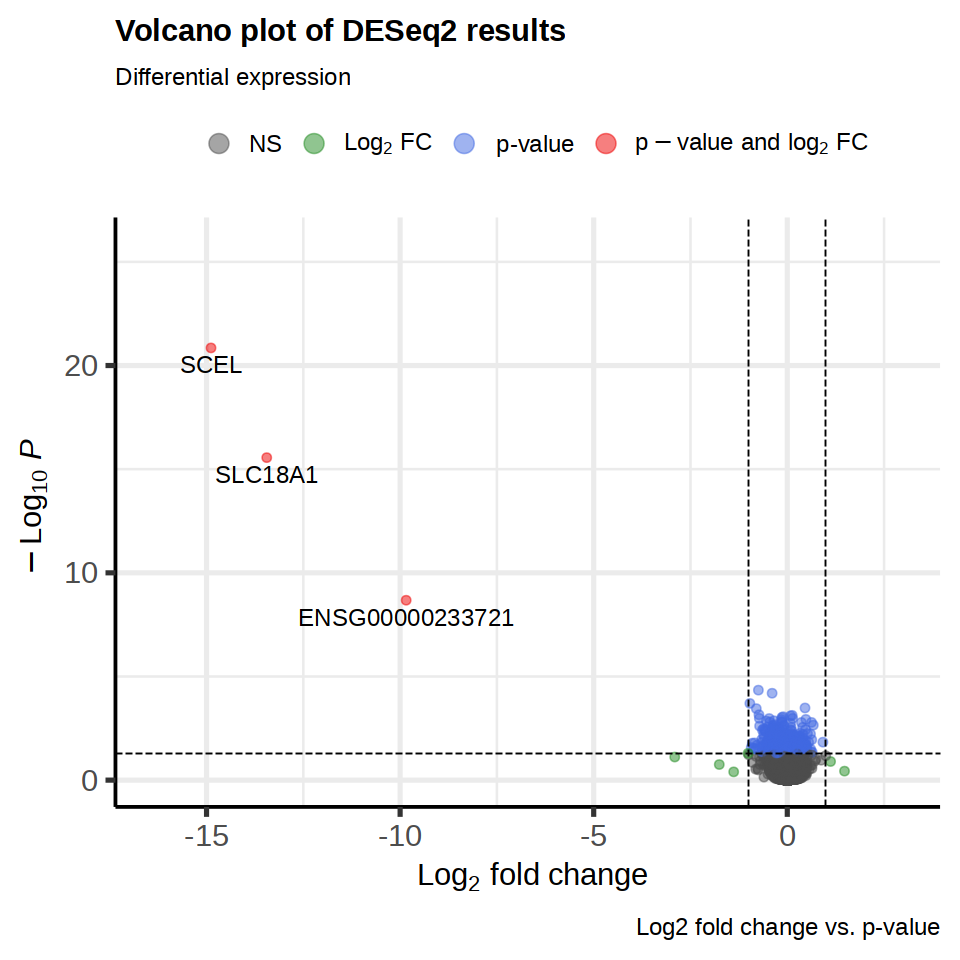

In [98]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



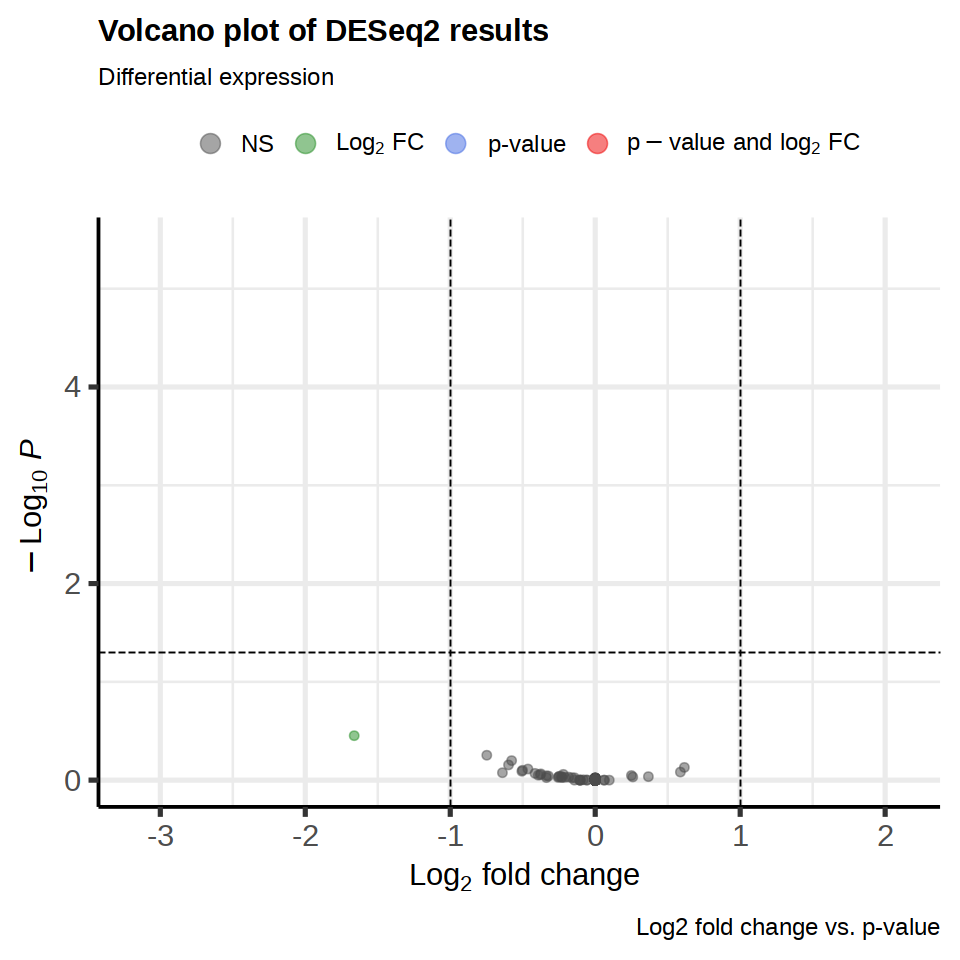

In [96]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



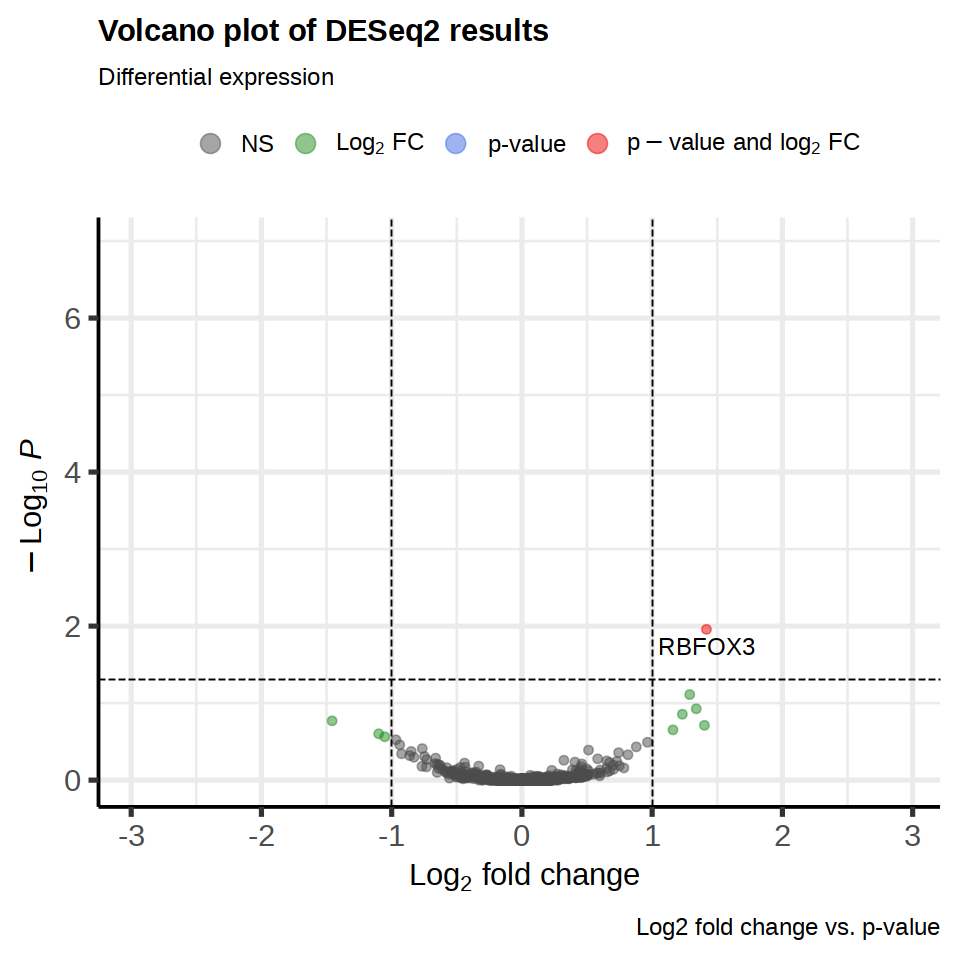

In [93]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



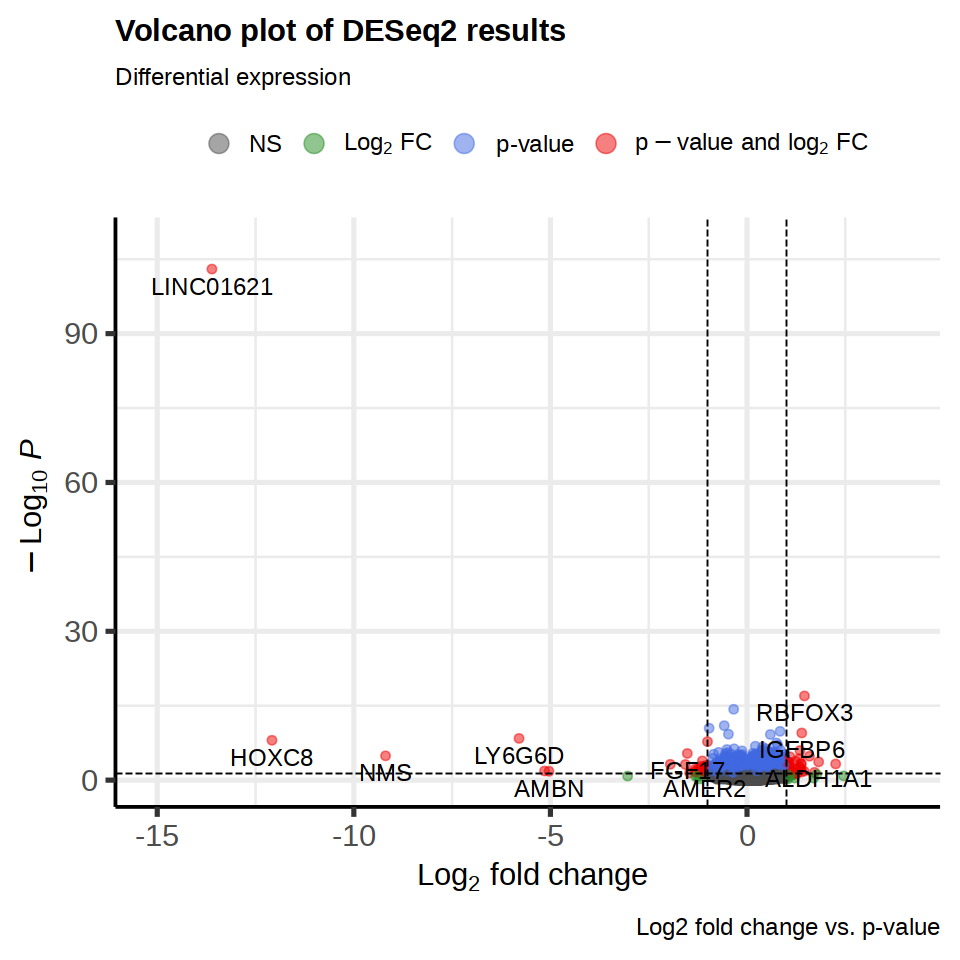

In [82]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


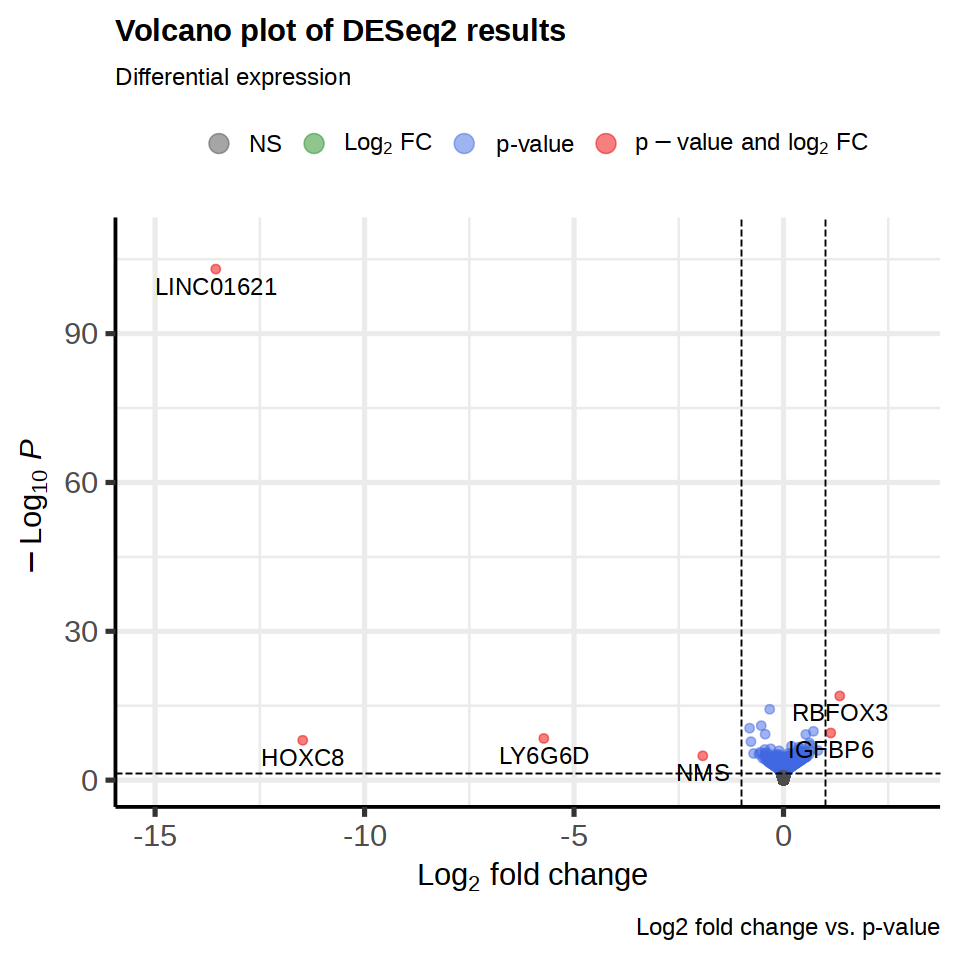

In [81]:
# Get results
res <- resAshT

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


In [93]:
table(vsd_l@colData$M_RA)


-0.247023184533617 -0.195228000679794  0.270928654004612   4.93249520084867 
               151                  8                 16                  7 

In [56]:
table(vsd@colData$M_RA)


-0.42279543647209 0.882246098889301  2.08895894809182  3.33725699238602 
              151                 8                16                 7 